In [1]:
#Imports
from matplotlib.pyplot import figure, grid, legend, plot, show, title, xlabel
from numpy import array, concatenate, cos, dot, exp, identity, linspace, ones, pi, reshape, sin, transpose, zeros
from numpy.linalg import eigvalsh, inv, norm, solve

from core.dynamics import AffineDynamics, AffineQuadCLF, FBLinDynamics, ScalarDynamics, SystemDynamics
from core.controllers import Controller, ConstantController, FBLinController, LQRController, QPController
from attitude_utils import dcm_from_euler, d_elem_euler_rot, dd_elem_euler_rot, elem_euler_rot, euler_to_ang, evec, ss_cross


$\newcommand{\mb}[1]{\mathbf{ #1 }}$
$\newcommand{\bs}[1]{\boldsymbol{ #1 }}$
$\newcommand{\norm}[1]{\left\Vert #1 \right\Vert}$
$\newcommand{\der}[2]{\frac{\mathrm{d} #1 }{\mathrm{d} #2}}$
$\newcommand{\derp}[2]{\frac{\partial #1 }{\partial #2}}$
$\newcommand{\bb}[1]{\mathbb{ #1 }}$
$\newcommand{\R}{\bb{R}}$
$\newcommand{\grad}{\bs{\nabla}}$

# Quadrotor Simulation


Consider a quadrotor system specified as follows:

- A quadrotor frame with mass $m$ and fixed inertia tensor $\cal{J}$ specified about the center of mass.
- Four propellers mounted a distance $l$ away from the center of mass. 

We specify an inertial reference $\bs{\cal{F}}_i$ and a reference frame attached to the quadrotor body, $\bs{\cal{F}}_b$. The attitude of the quadrotor relative to the inertial frame is given by the direction cosine matrix (DCM) $\mb{C}_{bi}\in SO(3)$. We parameterize the attitude using the conventional "1-2-3" Euler-angle parameterization, such that:

\begin{equation}
\mb{C}_{bi}(\bs{\xi}) = \mb{C}_{bi}(\phi,\theta,\psi) = \mb{C}_3(\psi)\mb{C}_2(\theta)\mb{C}_1(\phi)
\end{equation}
where $\bs{\xi} = \begin{bmatrix}\phi & \theta & \psi \end{bmatrix}^\top$ and 
\begin{equation}
\mb{C}_1(\phi) = \begin{bmatrix}1 & 0 & 0 \\ 0 & \cos(\phi) & \sin(\phi) \\ 0 & -\sin(\phi) & \cos(\phi) \end{bmatrix}, \quad \mb{C}_2(\theta) = \begin{bmatrix}\cos(\theta) & 0 & -\sin(\theta) \\ 0 & 1 & 0 \\ \sin(\theta) & 0 & \cos(\theta) \end{bmatrix}, \quad \mb{C}_3(\psi) = \begin{bmatrix}\cos(\psi) & \sin(\psi) & 0 \\ -\sin(\psi) & \cos(\psi) & 0 \\ 0 & 0 & 1 \end{bmatrix} \in SO(3)
\end{equation}
The inertia tensor may be resolved in the body frame and expressed as $\mb{J}\in{S}^{3}_{++}$, and it assumed that the propellers generate thrust entirely along the vector $\underrightarrow{b}^3$.

The position of the quadrotor's center of mass relative to the origin of the inertial frame resolved in the inertial frame is given by

\begin{equation}
\mb{r}^{bi}_i = \begin{bmatrix}x \\ y \\ z \end{bmatrix}
\end{equation}

and the velocity of the quadrotor's center of mass relative to the origin of inertial frame with respect to the inertial frame resolved in the inertial frame is given by

\begin{equation}
\dot{\mb{r}}^{bi}_i = \begin{bmatrix}\dot{x} \\ \dot{y} \\ \dot{z} \end{bmatrix}
\end{equation}

We denote the angular velocity of the body frame relative to the inertial frame as $\underrightarrow{\omega}^{bi}$, and note that the resolution of this angular velocity in the body frame can be related to the Euler angle rates as follows:

\begin{equation}
\bs{\omega}^{bi}_b = \mb{T}(\bs{\xi})\dot{\bs{\xi}}
\end{equation}

To compute $\mb{T}(\bs{\xi})$, construct two intermediate reference frames, $\bs{\cal{F}}_p$ and $\bs{\cal{F}}_q$ such that

\begin{equation}
    \bs{\cal{F}}_i \overset{\mb{C}_1(\phi)}{\rightarrow} \bs{\cal{F}}_p \overset{\mb{C}_2(\theta)}{\rightarrow} \bs{\cal{F}}_q \overset{\mb{C}_3(\psi)}{\rightarrow} \bs{\cal{F}}_b
\end{equation}

We may express the angular velocities between these intermediate frames as:

\begin{equation}
\underrightarrow{\omega}^{pi} =  \underrightarrow{\bs{\cal{F}}_p}^\top \mb{e}_1\dot{\phi}, \quad \underrightarrow{\omega}^{qp} =  \underrightarrow{\bs{\cal{F}}_q}^\top \mb{e}_2\dot{\theta}, \quad \underrightarrow{\omega}^{bq} =  \underrightarrow{\bs{\cal{F}}_b}^\top \mb{e}_3\dot{\psi}  
\end{equation}
where $\mb{e}_i,\,i\in\{1,2,3\}$, are elementary basis vectors. Noting that physical angular velocity vectors add linearly such that:

\begin{equation}
\underrightarrow{\omega}^{bi} = \underrightarrow{\omega}^{bq}+\underrightarrow{\omega}^{qp}+\underrightarrow{\omega}^{pi}
\end{equation}

we get that 

\begin{align}
\bs{\omega}^{bi}_b & = \mathbf{C}_{bp}\mb{e}_1\dot{\phi} + \mb{C}_{bq} \mb{e}_2\dot{\theta} + \mb{e}_3\dot{\psi} \\ & = \mb{C}_{3}(\psi)\mb{C}_{2}(\theta)\mb{e}_1\dot{\phi} + \mb{C}_{3}(\psi) \mb{e}_2\dot{\theta} + \mb{e}_3\dot{\psi} \\ & = \begin{bmatrix}\mb{C}_3(\psi)\mb{C}_2(\theta)\mb{e}_1 &\mb{C}_3(\psi)\mb{e}_2 & \mb{e}_3 \end{bmatrix}\dot{\bs{\xi}}  \\ & = \mb{T}(\bs{\xi})\dot{\bs{\xi}}
\end{align}
We note that this matrix has a kinematic singularity that occurs when $\theta=\pm\frac{k\pi}{2},\,k=\{1,3,...\}$, and thus is non-invertible at these locations.

We now specify the state as follows:

\begin{equation}
\mb{x} = \begin{bmatrix}\mb{r}^{bi}_i \\ \dot{\mb{r}}^{bi}_i \\ \bs{\xi} \\ \bs{\omega}^{bi}_b \end{bmatrix} \in \R^{12}
\end{equation}

Utilizing the Newton-Euler equations, the state dynamics are given by: 

\begin{equation}
\dot{\mb{x}} = \begin{bmatrix} \dot{\mb{r}}^{bi}_i \\ \frac{1}{m}(\mb{f}^g_i+\mb{C}^\top_{bi}(\bs{\xi})\mathbf{f}^t_b) \\ \mb{T}^{-1}(\bs{\xi})\bs{\omega}^{bi}_b \\ \mb{J}^{-1}\bs{\tau}_b - \mb{J}^{-1}\bs{\omega}^{{bi}^\times}_b\mb{J}\bs{\omega}^{bi}_b \end{bmatrix}
\end{equation}

Here $\mb{f}^g_i=-mg\mb{e}_3$ is the gravitational force in the inertial frame, $\mb{f}^t_b=f^t\mb{e}_3$ is the thrust generated by the quadrotor propellers in the body frame, $\bs{\tau}_b$ are the torques acting on the quadrotor resolved in the body frame, and $\bs{\omega}^{{bi}^\times}_b$ is the skew-symmetric cross operator applied to the angular velocity. The inputs to the system are considered to be $f^t$ and $\bs{\tau}_b$. Note that $\mb{T}^{-1}(\bs{\xi})$ is defined as $(\mb{T}(\bs{\xi}))^{-1}$.



In [2]:
# System definition and dynamics
class QuadrotorSystem(SystemDynamics, AffineDynamics):
    def __init__(self, m, J, l, rot_order, g=9.81):
        SystemDynamics.__init__(self, 12, 4)
        self.params = m, J, l, g 
        self.f_gravity = -m * g * array([0, 0, 1])
        self.rot_order = rot_order
        self.dcm, _, _ = dcm_from_euler(self.rot_order)
        self.T, _ = euler_to_ang(self.rot_order)
                
    def drift(self, x, t):
        r, r_dot, xi, omega = reshape(x, (4, 3))
        m, J, _, _ = self.params
        return concatenate([r_dot, self.f_gravity / m, solve(self.T(xi), omega), solve(-J, dot(ss_cross(omega), dot(J, omega)))])
    
    def act(self, x, t):
        _, _, xi, _ = reshape(x, (4, 3))
        _, J, _, _ = self.params
        return concatenate([zeros((3, 4)), concatenate([self.dcm(xi).T[:, 2:], zeros((3, 3))], 1) / m, zeros((3, 4)), concatenate([zeros((3, 1)), inv(J)], 1)])

# Dynamic Extension

The quadrotor presents an interesting control problem as it is not possible to achieve position tracking without using the quadrotors attitude to steer the vehicle. We will take a feedback linearization approach to solving the problem of positioning tracking, and will employ a tool known as dynamic extension to get the proper relative degree for the system.

Assuming position tracking is our control objective, we choose the following output:

\begin{equation}
\mb{y} = \mb{h}(\mb{x}) = \begin{bmatrix}\mb{r}^{bi}_i \\ \psi \end{bmatrix}
\end{equation}

Taking the time derivative of output yields:

\begin{equation}
\dot{\mb{y}} = \begin{bmatrix}\dot{\mb{r}}^{bi}_i \\ \dot{\psi} \end{bmatrix} = \begin{bmatrix}\dot{\mb{r}}^{bi}_i \\ \mb{e}^\top_3\mb{T}^{-1}(\bs{\xi})\bs{\omega}^{bi}_b \end{bmatrix}
\end{equation}

To simplify our notation and analysis, we will view $\mb{T},\mb{T}^{-1}:\R^3\to\R^{3\times 3}$ as multilinear operators, such that $\mb{T}(\bs{\xi})(\cdot,\cdot),\mb{T}^{-1}(\bs{\xi})(\cdot,\cdot):\R^3\times\R^3\to\R$. To demonstrate this notation we rewrite the preceding equation as:

\begin{equation}
\dot{\mb{y}} = \begin{bmatrix}\dot{\mb{r}}^{bi}_i \\ \mb{T}^{-1}(\bs{\xi})(\mb{e}_3,\bs{\omega}^{bi}_b) \end{bmatrix}
\end{equation}

Taking a further time derivative results in:

\begin{equation}
\ddot{\mb{y}} = \begin{bmatrix}\ddot{\mb{r}}^{bi}_i \\ \grad\mb{T}^{-1}(\bs{\xi})(\mb{e}_3,\bs{\omega}^{bi}_b,\dot{\bs{\xi}})+\mb{T}^{-1}(\bs{\xi})(\mb{e}_3,\dot{\bs{\omega}}^{bi}_b) \end{bmatrix} = \begin{bmatrix}\frac{1}{m}(\mb{f}^g_i+\mb{C}^\top_{bi}(\bs{\xi})\mathbf{f}^t_b)\\ \grad\mb{T}^{-1}(\bs{\xi})(\mb{e}_3,\bs{\omega}^{bi}_b,\dot{\bs{\xi}})+\mb{T}^{-1}(\bs{\xi})(\mb{e}_3,\dot{\bs{\omega}}^{bi}_b) \end{bmatrix}
\end{equation}

We wish to avoid the computation of $\grad\mb{T}^{-1}(\bs{\xi})$ and utilize the more readily computable $\grad\mb{T}(\bs{\xi})$, given by:

\begin{equation}
\grad\mb{T}(\bs{\xi})(\cdot,\cdot,\cdot)_{ijk} = \derp{T(\bs{\xi})(\cdot,\cdot)_{ij}}{\xi_k}
\end{equation}

we utilize the following steps:

\begin{equation}
\bs{\omega}^{bi}_b = \mb{T}(\bs{\xi})(\cdot,\dot{\bs{\xi}})
\end{equation}
\begin{equation}
\dot{\bs{\omega}}^{bi}_b = \grad\mb{T}(\bs{\xi})(\cdot,\dot{\bs{\xi}},\dot{\bs{\xi}})+\mb{T}(\bs{\xi})(\cdot,\ddot{\bs{\xi}})
\end{equation}
\begin{equation}
\ddot{\bs{\xi}} = \mb{T}^{-1}(\bs{\xi})(\cdot,\dot{\bs{\omega}}^{bi}_b-\grad\mb{T}(\bs{\xi})(\cdot,\dot{\bs{\xi}},\dot{\bs{\xi}}))
\end{equation}
\begin{equation}
\ddot{\psi}=\mb{T}^{-1}(\bs{\xi})(\mb{e}_3,\dot{\bs{\omega}}^{bi}_b-\grad\mb{T}(\bs{\xi})(\cdot,\dot{\bs{\xi}},\dot{\bs{\xi}}))
\end{equation}

Using the expression for $\dot{\bs{\omega}}^{bi}_b$, this can be further expressed as:

\begin{equation}
\ddot{\psi} = -\mb{T}^{-1}(\bs{\xi})(\mb{e}_3,\mb{J}^{-1}\bs{\omega}^{bi^\times}_b\mb{J}\bs{\omega}^{bi}_b+\grad\mb{T}(\bs{\xi})(\cdot,\dot{\bs{\xi}},\dot{\bs{\xi}}))+\mb{T}^{-1}(\bs{\xi})(\mb{e}_3,\cdot)\mb{J}^{-1}\bs{\tau}_b
\end{equation}

From this we conclude that $\ddot{\psi}$ has relative degree $\gamma_\psi=2$.

We can then write the $\ddot{\mb{y}}$ dynamics as 

\begin{equation}
\ddot{\mb{y}} = {\underbrace{\begin{bmatrix}\frac{1}{m}\mb{f}^g_i\\ -\mb{T}^{-1}(\bs{\xi})(\mb{e}_3,\mb{J}^{-1}\bs{\omega}^{bi^\times}_b\mb{J}\bs{\omega}^{bi}_b+\grad\mb{T}(\bs{\xi})(\cdot,\dot{\bs{\xi}},\dot{\bs{\xi}})) \end{bmatrix}}_{\mb{f}(\bs{\xi},\dot{\bs{\xi}},\bs{\omega}^{bi}_b)}} + {\underbrace{\begin{bmatrix} \frac{1}{m}\mb{C}^\top_{bi}(\bs{\xi})\mb{e}_3 & \mb{0}_{3\times 3}\\ 0 & \mb{T}^{-1}(\bs{\xi})(\mb{e}_3,\cdot)\mb{J}^{-1} \end{bmatrix}}_{\mb{g}(\bs{\xi})}} {\underbrace{\begin{bmatrix}f^t \\ \bs{\tau}_b \end{bmatrix}}_\mb{u}}
\end{equation}

Consider the scenario when $\bs{\xi}=\mb{0}$, which describes the quadrotor at the nominal operating position of a level hover. In this case the actuation matrix $\mb{g}(\mb{0})$ is:

\begin{equation}
\begin{bmatrix} \frac{1}{m}\mb{e}_3 & \mb{0}_{3\times 3}\\ 0 & \mb{e}^\top_3\mb{J}^{-1} \end{bmatrix} 
\end{equation}

This matrix has rank 2, which implies that it will not have the right pseudoinverse necessary for feedback linearization. This highlights the fact that the quadrotor can only thrust in the $\underrightarrow{b}^3$ direction, and must perturb its roll and pitch ($\phi$ and $\theta$) to enable thrust in the $x-y$ plane.

To resolve this non-invertibility, we will use the notion of dynamic extension. In particular, we will take an additional two time derivatives of $\ddot{\mb{r}}^{bi}_b$. In doing so, we will find that $\bs{\tau}_b$ appears in the dynamics for $\ddddot{\mb{r}}^{bi}_i$, and the corresponding actuation matrix will be full rank over a region in the state space we are interested in operating in (away from kinematic singularities). The extension will result in $f^t$ and $\dot{f^t}$ becoming states of the system, and the input of the system being described by $\ddot{f^t}$ and $\bs{\tau}_b$, such that the state is defined as

\begin{equation}
\mb{x} = \begin{bmatrix}\mb{r}^{bi}_i \\ \dot{\mb{r}}^{bi}_i \\ \bs{\xi} \\ \bs{\omega}^{bi}_b \\ f^t \\ \dot{f^t} \end{bmatrix} \in \R^{14}
\end{equation}

with state dynamics
\begin{equation}
\dot{\mb{x}} = \begin{bmatrix} \dot{\mb{r}}^{bi}_i \\ \frac{1}{m}(\mb{f}^g_i+\mb{C}^\top_{bi}(\bs{\xi})\mathbf{f}^t_b) \\ \mb{T}^{-1}(\bs{\xi})\bs{\omega}^{bi}_b \\ \mb{J}^{-1}\bs{\tau}_b - \mb{J}^{-1}\bs{\omega}^{{bi}^\times}_b\mb{J}\bs{\omega}^{bi}_b \\ \dot{f^t} \\ \ddot{f^t} \end{bmatrix}
\end{equation}

In [3]:
# Extended system definition and dynamics
class ExtendedQuadrotorSystem(SystemDynamics, AffineDynamics):
    def __init__(self, system):
        SystemDynamics.__init__(self, 14, 4)
        self.system = system
            
    def drift(self, x, t):
        
        state_dyn = self.system.drift(x[:12],t) + self.system.act(x[:12], t)[:, 0] * x[12]
        input_dyn = array([x[13], 0])
        
        return concatenate([state_dyn, input_dyn])
    
    def act(self, x, t):
        _, J, _, _ = self.system.params
        return concatenate([zeros((9, 4)), concatenate([zeros((3, 1)), inv(J)], 1), concatenate([array([[0], [1]]), zeros((2,3))], 1)])

In the same way that we considered $\mb{T}(\bs{\xi})$ to be a multilinear operator, we will consider $\mb{C}_{bi}(\bs{\xi})$ to be a multilinear operator to simplify the resulting time derivatives. This results in the expression:

\begin{equation}
\ddot{\mb{r}}^{bi}_i = \frac{1}{m}\mb{f}^g_i+\frac{1}{m}\mb{C}^\top_{bi}(\bs{\xi})(\cdot,\mb{e}_3)f^t
\end{equation}

Taking an additional time derivative results in
\begin{equation}
\dddot{\mb{r}}^{bi}_i = \frac{1}{m}\grad\mb{C}^\top_{bi}(\bs{\xi})(\cdot,\mb{e}_3,\dot{\bs{\xi}})f^t+\frac{1}{m}\mb{C}^\top_{bi}(\bs{\xi})(\cdot,\mb{e}_3)\dot{f^t}
\end{equation}
where 
\begin{equation}
\grad\mb{C}^\top_{bi}(\bs{\xi})(\cdot,\cdot,\cdot)_{ijk} = \derp{\mb{C}^\top_{bi}(\bs{\xi})_{ij}}{\xi_k}
\end{equation}

Taking one further derivative results in:

\begin{equation}
\ddddot{\mb{r}}^{bi}_b = \frac{1}{m}\grad^2\mb{C}^\top_{bi}(\bs{\xi})(\cdot,\mb{e}_3,\dot{\bs{\xi}},\dot{\bs{\xi}})f^t+\frac{1}{m}\grad\mb{C}^\top_{bi}(\bs{\xi})(\cdot,\mb{e}_3,\ddot{\bs{\xi}})f^t+\frac{2}{m}\grad\mb{C}^\top_{bi}(\bs{\xi})(\cdot,\mb{e}_3,\dot{\bs{\xi}})\dot{f^t}+\frac{1}{m}\mb{C}^\top_{bi}(\bs{\xi})(\cdot,\mb{e}_3)\ddot{f^t}
\end{equation}

where

\begin{equation}
\grad^2\mb{C}^\top_{bi}(\bs{\xi})(\cdot,\cdot,\cdot,\cdot)_{ijkl} = \derp{\mb{C}^\top_{bi}(\bs{\xi})_{ij}}{\xi_k\xi_l}
\end{equation}

To produce $\bs{\tau}_b$ we utilize our previous expression for $\ddot{\bs{\xi}}$ such that:
\begin{equation}
\ddddot{\mb{r}}^{bi}_b = \frac{1}{m}\grad^2\mb{C}^\top_{bi}(\bs{\xi})(\cdot,\mb{e}_3,\dot{\bs{\xi}},\dot{\bs{\xi}})f^t+\frac{1}{m}\grad\mb{C}^\top_{bi}(\bs{\xi})(\cdot,\mb{e}_3,\mb{T}^{-1}(\bs{\xi})(\cdot,\dot{\bs{\omega}}^{bi}_b-\grad\mb{T}(\bs{\xi})(\cdot,\dot{\bs{\xi}},\dot{\bs{\xi}})))f^t+\frac{2}{m}\grad\mb{C}^\top_{bi}(\bs{\xi})(\cdot,\mb{e}_3,\dot{\bs{\xi}})\dot{f^t}+\frac{1}{m}\mb{C}^\top_{bi}(\bs{\xi})(\cdot,\mb{e}_3)\ddot{f^t}
\end{equation}

Utilizing our expression for $\dot{\bs{\omega}}^{bi}_b$ yields:

\begin{align}
\ddddot{\mb{r}}^{bi}_b = & \frac{1}{m}\grad^2\mb{C}^\top_{bi}(\bs{\xi})(\cdot,\mb{e}_3,\dot{\bs{\xi}},\dot{\bs{\xi}})f^t+\frac{2}{m}\grad\mb{C}^\top_{bi}(\bs{\xi})(\cdot,\mb{e}_3,\dot{\bs{\xi}})\dot{f^t} \nonumber \\ & + \frac{1}{m}\grad\mb{C}^\top_{bi}(\bs{\xi})(\cdot,\mb{e}_3,-\mb{T}^{-1}(\bs{\xi})(\cdot,\mb{J}^{-1}\bs{\omega}^{bi^\times}_b\mb{J}\bs{\omega}^{bi}_b+\grad\mb{T}(\bs{\xi})(\cdot,\dot{\bs{\xi}},\dot{\bs{\xi}}))+\mb{T}^{-1}(\bs{\xi})(\cdot,\cdot)\mb{J}^{-1}\bs{\tau}_b)f^t+ \frac{1}{m}\mb{C}^\top_{bi}(\bs{\xi})(\cdot,\mb{e}_3)\ddot{f^t}
\end{align}

Separating into drift and acutation expressions leads to:

\begin{align}
\ddddot{\mb{r}}^{bi}_b = & {\underbrace{\frac{1}{m}\grad^2\mb{C}^\top_{bi}(\bs{\xi})(\cdot,\mb{e}_3,\dot{\bs{\xi}},\dot{\bs{\xi}})f^t+\frac{2}{m}\grad\mb{C}^\top_{bi}(\bs{\xi})(\cdot,\mb{e}_3,\dot{\bs{\xi}})\dot{f^t} \nonumber + \frac{1}{m}\grad\mb{C}^\top_{bi}(\bs{\xi})(\cdot,\mb{e}_3,-\mb{T}^{-1}(\bs{\xi})(\cdot,\mb{J}^{-1}\bs{\omega}^{bi^\times}_b\mb{J}\bs{\omega}^{bi}_b+\grad\mb{T}(\bs{\xi}) (\cdot,\dot{\bs{\xi}},\dot{\bs{\xi}})))}_{\mb{f}_e(\bs{\xi},\dot{\bs{\xi}},\bs{\omega}^{bi}_b,f^t,\dot{f^t})}} \nonumber \\ & +{\underbrace{\begin{bmatrix} \frac{1}{m}\mb{C}^\top_{bi}(\bs{\xi})(\cdot,\mb{e}_3) & \frac{1}{m}\grad\mb{C}^\top_{bi}(\bs{\xi})(\cdot,\mb{e}_3,\cdot)\mb{T}^{-1}(\bs{\xi})(\cdot,\cdot)\mb{J}^{-1}f^t \end{bmatrix}}_{\mb{g}_e(\bs{\xi},f^t)}}{\underbrace{\begin{bmatrix}\ddot{f^t} \\ \bs{\tau}_b\end{bmatrix}}_{\mb{u}_e}}
\end{align}

We may define our output coordinates $\bs{\eta}$ as follows:

\begin{equation}
\bs{\eta} = \begin{bmatrix} \mb{r}^{bi}_i \\ \dot{\mb{r}}^{bi}_b \\ \ddot{\mb{r}}^{bi}_b \\ \dddot{\mb{r}}^{bi}_b \\ \psi \\ \dot{\psi} \end{bmatrix}
\end{equation}

with output dynamics

\begin{equation}
\dot{\bs{\eta}} = \begin{bmatrix} \dot{\mb{r}}^{bi}_b \\ \ddot{\mb{r}}^{bi}_b \\ \dddot{\mb{r}}^{bi}_b \\ \mb{f}_e(\bs{\xi},\dot{\bs{\xi}},\bs{\omega}^{bi}_b,f^t,\dot{f^t})\\ \dot{\psi} \\ -\mb{T}^{-1}(\bs{\xi})(\mb{e}_3,\mb{J}^{-1}\bs{\omega}^{bi^\times}_b\mb{J}\bs{\omega}^{bi}_b+\grad\mb{T}(\bs{\xi})(\cdot,\dot{\bs{\xi}},\dot{\bs{\xi}})) \end{bmatrix} + \begin{bmatrix} \mathbf{0}_{9\times 4} \\ \mb{g}_e(\bs{\xi},f^t) \\ \mb{0}_{1\times 4} \\ \array{0 & \mb{T}^{-1}(\bs{\xi})(\mb{e}_3,\cdot)\mb{J}^{-1}}\end{bmatrix}\mb{u}_e 
\end{equation}

In [4]:
class ExtendedQuadrotorOutput(FBLinDynamics):
    def __init__(self, extended_system):
        perm = array([0, 3, 6, 9, 1, 4, 7, 10, 2, 5, 8, 11, 12, 13])
        FBLinDynamics.__init__(self, [4, 4, 4, 2], perm)
        self.extended_system = extended_system
        self.dcm, self.graddcm, self.hessdcm = dcm_from_euler(extended_system.system.rot_order)
        self.T, self.gradT = euler_to_ang(extended_system.system.rot_order)
 
    def ddr(self, x, t):
        _, _, xi, _ = reshape(x[:12], (4, 3))
        f_t, _ = x[12:]
        m, _, _, _ = self.extended_system.system.params
        Cib = self.dcm(xi).T
        
        return self.extended_system.system.f_gravity / m + Cib[:, 2] * (f_t / m)

    def dddr(self, x, t):
        _, _, xi, omega = reshape(x[:12], (4, 3))
        T = self.T(xi)
        xi_dot = solve(T, omega)
        f_t, df_t = x[12:]
        m, _, _, _ = self.extended_system.system.params
        
        Cib = self.dcm(xi).T
        gradCib = transpose(self.graddcm(xi), [1, 0, 2])
        e3 = evec(3, 2)
        
        return dot(dot(gradCib, xi_dot), e3) * (f_t / m) + Cib[:, 2] * (df_t / m)
      
    def ddddr_drift(self, x, t):
        
        r, dr, xi, omega = reshape(x[:12], (4, 3))
        T = self.T(xi)
        gradT = self.gradT(xi)
        xi_dot = solve(T, omega)
        f_t, df_t = x[12:]
        m, J, _, _ = self.extended_system.system.params
        
        Cib = self.dcm(xi).T
        gradCib = transpose(self.graddcm(xi), [1, 0, 2])
        hessCib = transpose(self.hessdcm(xi), [1, 0, 2, 3])
        e3 = evec(3, 2)
        
        f_xi = -solve(T, solve(J, dot(ss_cross(omega), dot(J, omega))) - dot(dot(gradT, xi_dot), xi_dot))
        f_e = dot(dot(dot(hessCib, xi_dot), xi_dot), e3) * (f_t / m) + dot(dot(gradCib, 2 * df_t * xi_dot + f_xi), e3) / m
    
        return f_e, f_xi
    
    def eval(self, x, t):
        
        r, dr, xi, omega = reshape(x[:12], (4, 3))
        T = self.T(xi)
        xi_dot = solve(T, omega)
        
        r_d = 1*array([sin(t), cos(t), 0.5*sin(2*t)+1])
        dr_d = 1*array([cos(t), -sin(t), cos(2*t)])
        ddr_d = 1*array([-sin(t), -cos(t), -2*sin(2*t)])
        dddr_d = 1*array([-cos(t), sin(t), -4*cos(2*t)])

#         r_d = 1*array([0, 0, 0.5*sin(2*t)+.6])
#         dr_d = 1*array([0, 0, cos(2*t)])
#         ddr_d = 1*array([0, 0, -2*sin(2*t)])
#         dddr_d = 1*array([0, 0, -4*cos(2*t)])
        
        return concatenate([r-r_d, dr-dr_d, self.ddr(x, t)-ddr_d, self.dddr(x, t)-dddr_d, xi[2:], xi_dot[2:]])
    
    def drift(self, x, t):
    
        _, _, xi, omega = reshape(x[:12], (4, 3))
        T = self.T(xi)
        xi_dot = solve(T, omega)

        eta = self.eval(x, t)
        _, eta_dr, eta_ddr, eta_dddr = reshape(eta[:12], (4,3))
        
        f_e, f_xi = self.ddddr_drift(x, t)
        
        #dr_d = 1*array([cos(t), -sin(t), cos(2*t)])
        #ddr_d = 1*array([-sin(t), -cos(t), -2*sin(2*t)])
        #dddr_d = 1*array([-cos(t), sin(t), -4*cos(2*t)])
        ddddr_d = 1*array([sin(t), cos(t), 8*sin(2*t)])

#         dr_d = 1*array([0, 0, cos(2*t)])
#         ddr_d = 1*array([0, 0, -2*sin(2*t)])
#         dddr_d = 1*array([0, 0, -4*cos(2*t)])
#         ddddr_d = 1*array([0, 0, 8*sin(2*t)])
        
        return concatenate([eta_dr, eta_ddr, eta_dddr, f_e-ddddr_d, xi_dot[2:], f_xi[2:]])
        
    def act(self, x, t):
        
        _, _, xi, _ = reshape(x[:12], (4, 3))
        T = self.T(xi)
        f_t = x[12]
        m, J, _, _ = self.extended_system.system.params
        
        Cib = self.dcm(xi).T
        gradCib = transpose(self.graddcm(xi), [1, 0, 2])
        e3 = evec(3, 2)
    
        T_inv = inv(T)
        J_inv = inv(J)
    
        g_e = concatenate([Cib[:,2:] / m, dot(dot(gradCib[:, 2, :], T_inv), J_inv)  * (f_t / m)], 1)
        g_psi = concatenate([array([0]), dot(dot(e3, T_inv), J_inv)])
    
        return concatenate([zeros((9,4)), g_e, zeros((1,4)), array([g_psi])])
        

In [5]:
# System Setup
m, J, l, rot_order = 2, array([[1, 0, 0], [0, 1, 0], [0, 0, 2]]), 0.25, array([1, 2, 3])
system = QuadrotorSystem(m, J, l, rot_order)
extended_system = ExtendedQuadrotorSystem(system)
output = ExtendedQuadrotorOutput(extended_system)

In [6]:
# Feedback Linearization Simulation
Q = 10*identity(14)
R = 1*identity(4)
lqr_controller = LQRController.build(output, Q, R)
fblin_controller = FBLinController(output, lqr_controller)

In [7]:
x_0 = array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, m*9.81, 0])
ts = linspace(0, 20, 2000+1)
xs, us = extended_system.simulate(x_0, fblin_controller, ts, atol = 1e-6, rtol = 1e-6)
us = array(us)

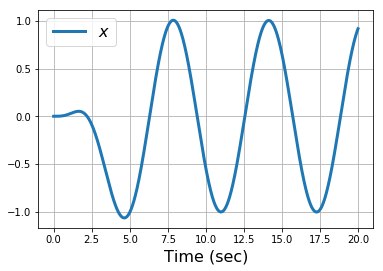

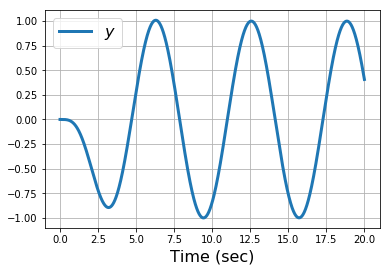

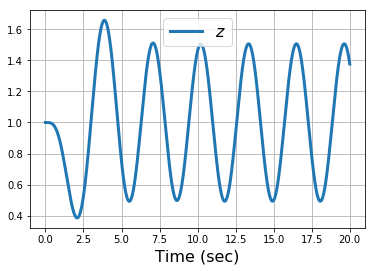

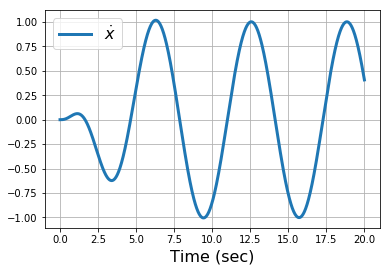

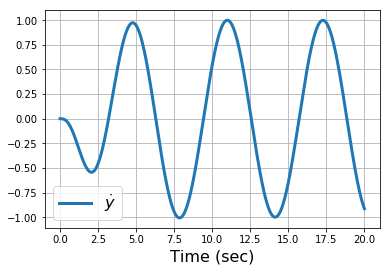

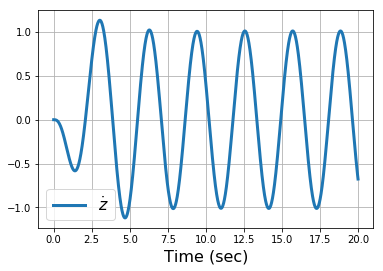

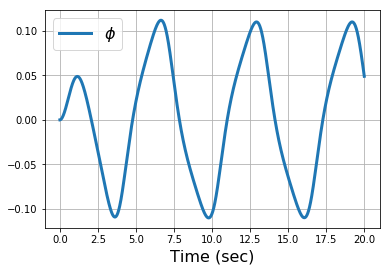

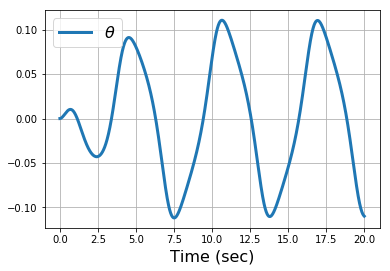

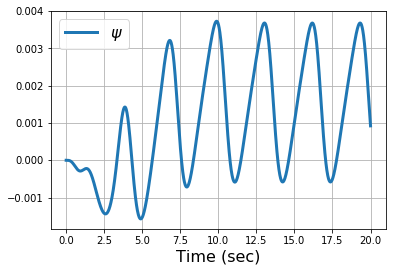

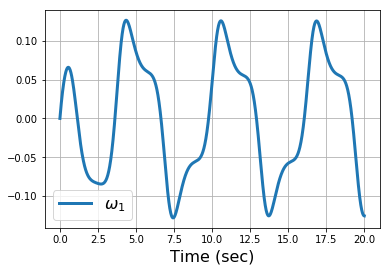

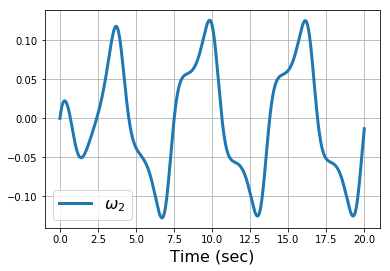

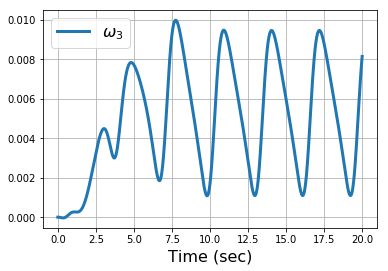

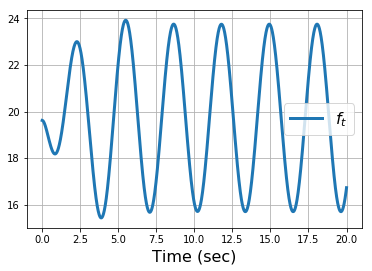

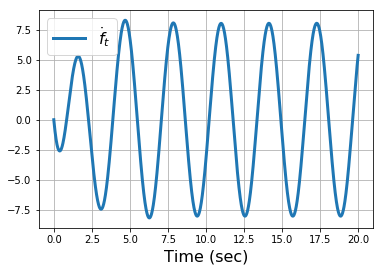

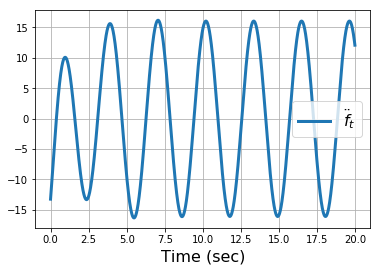

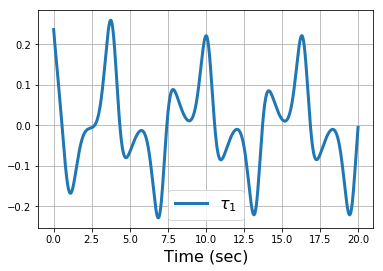

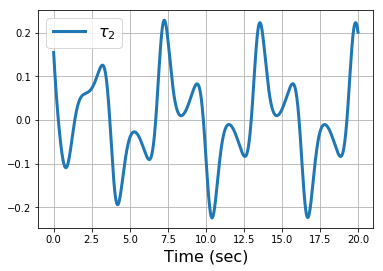

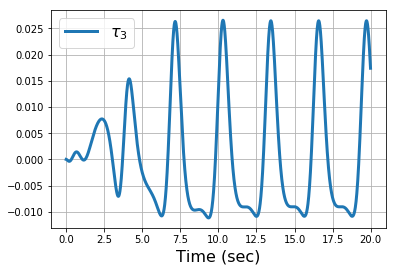

In [8]:
# Extended FBL simulation plotting

figure()
plot(ts, xs[:, 0], linewidth=3, label='$x$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts, xs[:, 1], linewidth=3, label='$y$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts, xs[:, 2], linewidth=3, label='$z$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts, xs[:, 3], linewidth=3, label='$\\dot{x}$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts, xs[:, 4], linewidth=3, label='$\\dot{y}$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts, xs[:, 5], linewidth=3, label='$\\dot{z}$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts, xs[:, 6], linewidth=3, label='$\\phi$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts, xs[:, 7], linewidth=3, label='$\\theta$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts, xs[:, 8], linewidth=3, label='$\\psi$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts, xs[:, 9], linewidth=3, label='$\\omega_1$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts, xs[:, 10], linewidth=3, label='$\\omega_2$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts, xs[:, 11], linewidth=3, label='$\\omega_3$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts, xs[:, 12], linewidth=3, label='$f_t$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts, xs[:, 13], linewidth=3, label='$\\dot{f}_t$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts[:-1], us[:, 0], linewidth=3, label='$\\ddot{f}_t$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts[:-1], us[:, 1], linewidth=3, label='$\\tau_1$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts[:-1], us[:, 2], linewidth=3, label='$\\tau_2$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts[:-1], us[:, 3], linewidth=3, label='$\\tau_3$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

show()

In [7]:
# QP Controller setup
lyap = AffineQuadCLF.build_care(output, Q, R)
reg_coeff = 1e1
alpha = -min(eigvalsh(Q))/max(eigvalsh(lyap.P))
comp = lambda r: alpha * r
relax_coeff = 1e4

qp_controller = QPController(output, 4)
qp_controller.add_stability_constraint(lyap, comp, True, relax_coeff)
qp_controller.add_regularizer(fblin_controller, reg_coeff)

In [20]:
# QP Simulation
x_0 = array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, m*9.81, 0])
ts = linspace(0, 20, 2000+1)
xs, us = extended_system.simulate(x_0, qp_controller, ts, atol = 1e-6, rtol = 1e-6)
us = array(us)

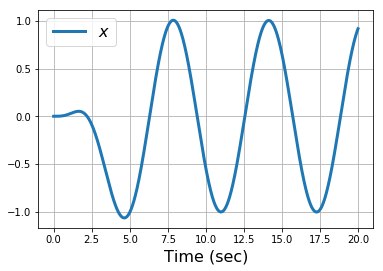

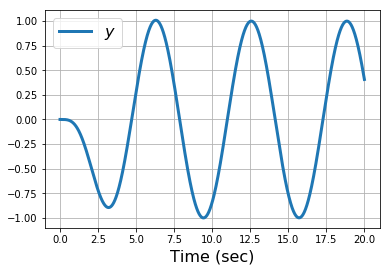

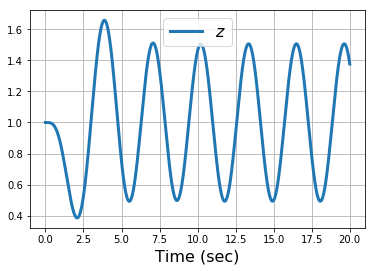

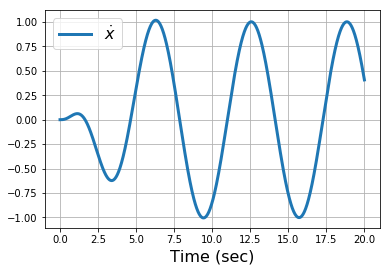

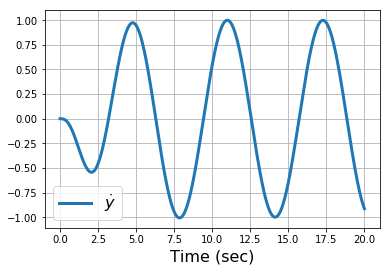

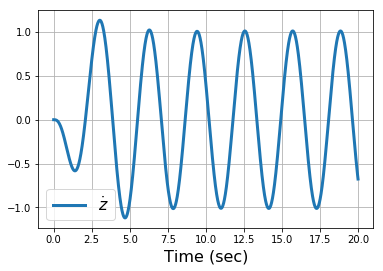

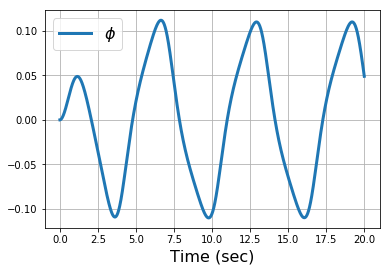

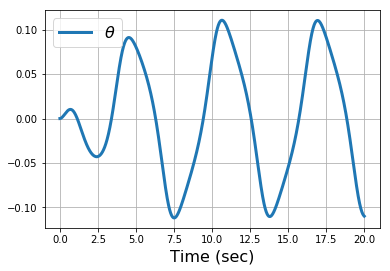

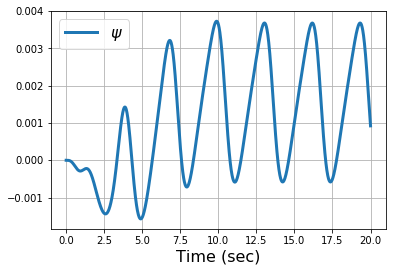

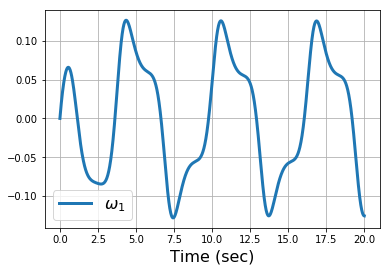

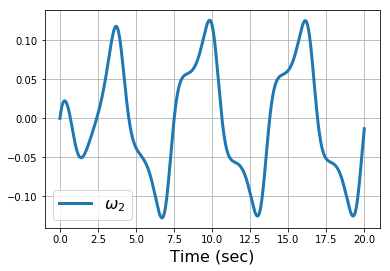

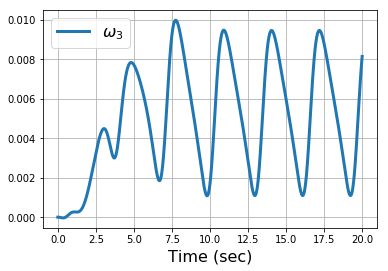

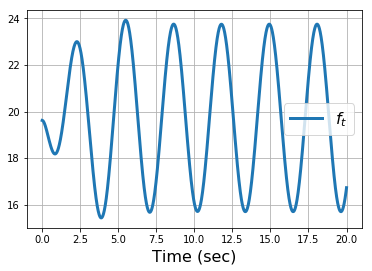

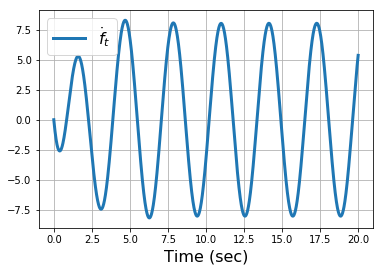

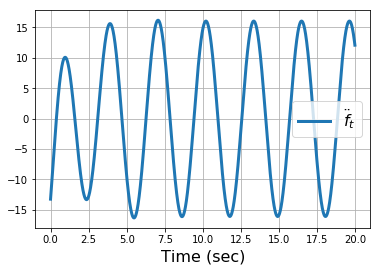

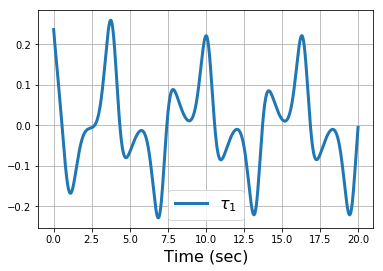

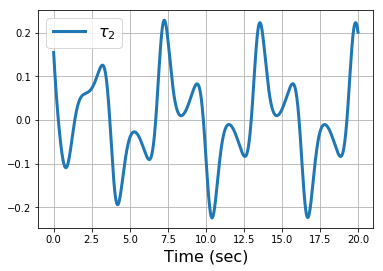

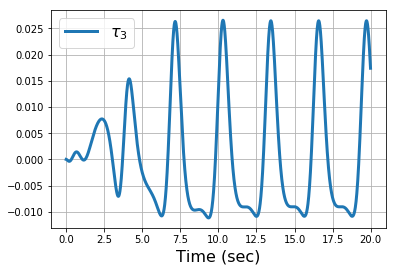

In [21]:
# Extended QP simulation plotting

figure()
plot(ts, xs[:, 0], linewidth=3, label='$x$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts, xs[:, 1], linewidth=3, label='$y$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts, xs[:, 2], linewidth=3, label='$z$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts, xs[:, 3], linewidth=3, label='$\\dot{x}$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts, xs[:, 4], linewidth=3, label='$\\dot{y}$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts, xs[:, 5], linewidth=3, label='$\\dot{z}$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts, xs[:, 6], linewidth=3, label='$\\phi$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts, xs[:, 7], linewidth=3, label='$\\theta$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts, xs[:, 8], linewidth=3, label='$\\psi$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts, xs[:, 9], linewidth=3, label='$\\omega_1$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts, xs[:, 10], linewidth=3, label='$\\omega_2$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts, xs[:, 11], linewidth=3, label='$\\omega_3$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts, xs[:, 12], linewidth=3, label='$f_t$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts, xs[:, 13], linewidth=3, label='$\\dot{f}_t$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts[:-1], us[:, 0], linewidth=3, label='$\\ddot{f}_t$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts[:-1], us[:, 1], linewidth=3, label='$\\tau_1$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts[:-1], us[:, 2], linewidth=3, label='$\\tau_2$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts[:-1], us[:, 3], linewidth=3, label='$\\tau_3$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

show()

In [8]:
# Ground Safety

class SafetyGround(AffineDynamics, ScalarDynamics):
    def __init__(self, extended_quadrotor_output, ground_thresh, alphas):
        self.output = extended_quadrotor_output
        self.ground_thresh = ground_thresh
        self.alphas = alphas
    
    def h(self, x, t):
        z, _, _, _ = x[array([2, 5, 8, 11])]
        
        return z - self.ground_thresh
    
    def h_dot(self, x, t):
        _, z_dot, _, _ = x[array([2, 5, 8, 11])]
        
        return z_dot
    
    def h_e1(self, x, t):
        alpha_1, _, _ = self.alphas
        
        return self.h_dot(x, t) + alpha_1 * self.h(x, t)
    
    def h_e1_dot(self, x, t):
        _, _, z_ddot, _ = x[array([2, 5, 8, 11])]
        alpha_1, _, _ = self.alphas
            
        return z_ddot + alpha_1 * self.h_dot(x, t)
    
    def h_e2(self, x, t):
        _, alpha_2, _ = self.alphas
        
        return self.h_e1_dot(x, t) + alpha_2 * self.h_e1(x, t)
    
    def h_e2_dot(self, x, t):
        _, _, z_ddot, z_dddot = x[array([2, 5, 8, 11])]
        alpha_1, alpha_2, _ = self.alphas
        
        return z_dddot + alpha_1 * z_ddot + alpha_2 * self.h_e1_dot(x, t)
    
    def eval(self, x, t):
        _, _, alpha_3 = self.alphas
        
        return self.h_e2_dot(x, t) + alpha_3 * self.h_e2(x, t)
       
    def drift(self, x, t):
        z, z_dot, z_ddot, z_dddot = x[array([2, 5, 8, 11])]
        alpha_1, alpha_2, alpha_3 = self.alphas
        f_e, f_xi = self.output.ddddr_drift(x, t)
        #return self.dynamics.drift(x, t)[11] + (alpha_1 + alpha_2 + alpha_3) * z_dddot + (alpha_1 * alpha_2 + alpha_1 * alpha_3 + alpha_2 * alpha_3) * z_ddot + alpha_1 * alpha_2 * alpha_3 * z_dot
        return f_e[2] + alpha_1 * z_dddot + alpha_2 * (z_dddot + alpha_1 * z_ddot) + alpha_3 * self.h_e2_dot(x, t)
        
    def act(self, x, t):
        print(t)
        return self.output.act(x, t)[11]
  

In [13]:
# Point Safety

class SafetyPoint(AffineDynamics, ScalarDynamics):
    def __init__(self, extended_quadrotor, extended_quadrotor_output, p, dist, alphas):
        self.dynamics = extended_quadrotor
        self.output = extended_quadrotor_output
        self.p = p
        self.dist = dist
        self.alphas = alphas
        
    def h(self, x, t):
        r, _, _, _ = reshape(x[:12], (4, 3))
        
        return 0.5 * norm(r-self.p) ** 2 - 0.5 * self.dist ** 2
    
    def h_dot(self, x, t):
        r, dr, _, _ = reshape(x[:12], (4, 3))
        
        return dot(r, dr) - dot(self.p, dr)
    
    def h_e1(self, x, t):
        alpha_1, _, _ = self.alphas
        
        return self.h_dot(x, t) + alpha_1 * self.h(x, t)
    
    def h_e1_dot(self, x, t):
        r, dr, _, _ = reshape(x[:12], (4, 3))
        ddr = self.output.ddr(x, t)
        alpha_1, _, _ = self.alphas
        
        return dot(r, ddr) + dot(dr, dr) - dot(self.p, ddr) + alpha_1 * self.h_dot(x, t)
    
    def h_e2(self, x, t):
        _, alpha_2, _ = self.alphas
        
        return self.h_e1_dot(x, t) + alpha_2 * self.h_e1(x, t)
    
    def h_e2_dot(self, x , t):
        r, dr, _, _ = reshape(x[:12], (4, 3))
        ddr = self.output.ddr(x, t)
        dddr = self.output.dddr(x, t)
        alpha_1, alpha_2, _ = self.alphas
        
        return dot(r, dddr) + 3 * dot(dr, ddr) - dot(self.p, dddr) + alpha_1 * (self.h_e1_dot(x, t) - alpha_1 * self.h_dot(x, t)) + alpha_2 * self.h_e1_dot(x, t)
    
    def eval(self, x, t):
        _, _, alpha_3 = self.alphas
        
        return self.h_e2_dot(x, t) + alpha_3 * self.h_e2(x, t)
    
    def drift(self, x, t):
        r, dr, _, _ = reshape(x[:12], (4, 3))
        ddr = self.output.ddr(x, t)
        dddr = self.output.dddr(x, t)
        alpha_1, alpha_2, _ = self.alphas
        
        return
    
    def act(self, x, t):
        
        return 
    

In [9]:
# QP + Ground Safety Simulation

qp_controller = QPController(extended_system, 4)
qp_controller.add_stability_constraint(lyap, comp, True, relax_coeff)
qp_controller.add_regularizer(fblin_controller, reg_coeff)

alphas = array([100, 100, 100])
safe = SafetyGround(output, .4, alphas)
alpha_e = 100
comp_safety = lambda r: alpha_e * r
qp_controller.add_safety_constraint(safe, comp_safety)


In [ ]:
# QP Simulation
x_0 = array([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, m*9.81, 0])
ts = linspace(0, 1.97, 197+1)
xs, us = extended_system.simulate(x_0, qp_controller, ts, atol = 1e-6, rtol = 1e-6)
us = array(us)
hs = array([safe.h(x, t) for x, t in zip(xs, ts)])
h_e1s = array([safe.h_e1(x, t) for x, t in zip(xs, ts)])
h_e2s = array([safe.h_e2(x, t) for x, t in zip(xs, ts)])
h_e3s = array([safe.eval(x, t) for x, t in zip(xs, ts)])

0.0
0.0
0.0008924316270945175
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0009056472544553719
0.0037671228880963616
0.005840962678189667
0.0009056472544553719
0.0037671228880963616
0.005840962678189667
0.005840962678189667
0.006485825680951117
0.008523329532876482
0.01
0.006485825680951117
0.008523329532876482
0.01
0.01
0.01
0.01
0.01103944515161349
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.010931008268104675
0.013872614352365266
0.016004528275587425
0.010931008268104675
0.013872614352365266
0.016004528275587425
0.016004528275587425
0.016624030264699573
0.018581403666005337
0.02
0.016624030264699573
0.018581403666005337
0.02
0.02
0.02
0.02
0.021198790355719883
0.02
0.02
0.02
0.02
0.02
0.02
0.02
0.02
0.02
0.02
0.02
0.02
0.02
0.02
0.02
0.020953451772578003
0.023965970169406214
0.026149277427480275
0.020953451772578003
0.023965970169406214
0.026149277427480275
0.026149277427480275
0.02674633591211909
0.028632797000857236
0.

0.25
0.25
0.25
0.25
0.259535881488562
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.2511829682543319
0.2549206650435495
0.25762954162235174
0.2511829682543319
0.2549206650435495
0.25762954162235174
0.25762954162235174
0.25799708362523666
0.25915836632158545
0.26
0.25799708362523666
0.25915836632158545
0.26
0.26
0.26
0.26
0.2704295278206238
0.26
0.26
0.26
0.26
0.26
0.26
0.26
0.26
0.26
0.26
0.26
0.26
0.26
0.26
0.2611877797345347
0.2649406788371191
0.2676605732145672
0.2611877797345347
0.2649406788371191
0.2676605732145672
0.2676605732145672
0.26802330373724936
0.26916938412023134
0.27
0.26802330373724936
0.26916938412023134
0.27
0.27
0.27
0.27
0.28144592504461546
0.27
0.27
0.27
0.27
0.27
0.27
0.27
0.27
0.27
0.27
0.27
0.27
0.27
0.27
0.27119237709381516
0.2749598019750572
0.27769022383609043
0.27119237709381516
0.2749598019750572
0.27769022383609043
0.27769022383609043
0.2780483569994921
0.27917991160381644
0.28
0.2780483569994921
0.27917991160381644
0.28
0.28
0.2

0.47933764560117903
0.48
0.48
0.48
0.48
0.4939053771517082
0.48
0.48
0.48
0.48
0.48
0.48
0.48
0.48
0.48
0.48
0.48
0.48
0.48
0.48
0.4812640748605753
0.48525803541733725
0.48815263784739077
0.4812640748605753
0.48525803541733725
0.48815263784739077
0.48815263784739077
0.48843907324403224
0.4893440921728367
0.49
0.48843907324403224
0.4893440921728367
0.49
0.49
0.49
0.49
0.5028296063828464
0.49
0.49
0.49
0.49
0.49
0.49
0.49
0.49
0.49
0.49
0.49
0.49
0.49
0.49
0.49126679794923184
0.4952693623545678
0.4981702003797496
0.49126679794923184
0.4952693623545678
0.4981702003797496
0.4981702003797496
0.49845391268773453
0.49935032776796495
0.5
0.49845391268773453
0.49935032776796495
0.5
0.5
0.5
0.5
0.5118849623688899
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5012694356220107
0.5052803339966143
0.5081872120232812
0.5012694356220107
0.5052803339966143
0.5081872120232812
0.5081872120232812
0.5084682866584874
0.50935636776945
0.51
0.5084682866584874
0.50935636776945
0.51
0.51
0.51
0.51
0

0.71
0.71
0.71
0.71
0.71
0.71
0.71
0.71
0.71
0.71
0.71
0.71
0.71
0.71
0.7113084693053617
0.7154426981855802
0.7184389593636774
0.7113084693053617
0.7154426981855802
0.7184389593636774
0.7184389593636774
0.7186810003155325
0.7194457509208804
0.72
0.7186810003155325
0.7194457509208804
0.72
0.72
0.72
0.72
0.723229057350442
0.72
0.72
0.72
0.72
0.72
0.72
0.72
0.72
0.72
0.72
0.72
0.72
0.72
0.72
0.7213094175097959
0.7254466423289639
0.7284450747984499
0.7213094175097959
0.7254466423289639
0.7284450747984499
0.7284450747984499
0.7286861675458707
0.7294479222122692
0.73
0.7286861675458707
0.7294479222122692
0.73
0.73
0.73
0.73
0.7330336308092951
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.7313102397513463
0.7354500625181699
0.7384503778368954
0.7313102397513463
0.7354500625181699
0.7384503778368954
0.7384503778368954
0.7386906483427658
0.7394498050615086
0.74
0.7386906483427658
0.7394498050615086
0.74
0.74
0.74
0.74
0.742844437700483
0.74
0.74
0.74
0.74
0.74
0.74
0.7

0.9414418935100791
0.9459976884126733
0.9492994774034403
0.9492994774034403
0.9494080941505781
0.9497512787335504
0.9500000000000001
0.9494080941505781
0.9497512787335504
0.9500000000000001
0.9500000000000001
0.9500000000000001
0.9500000000000001
0.9527745205739405
0.9500000000000001
0.9500000000000001
0.9500000000000001
0.9500000000000001
0.9500000000000001
0.9500000000000001
0.9500000000000001
0.9500000000000001
0.9500000000000001
0.9500000000000001
0.9500000000000001
0.9500000000000001
0.9500000000000001
0.9500000000000001
0.9514586406184461
0.9560673495472135
0.9594074877070744
0.9514586406184461
0.9560673495472135
0.9594074877070744
0.9594074877070744
0.9594993573458452
0.959789627902644
0.96
0.9594993573458452
0.959789627902644
0.96
0.96
0.96
0.96
0.9629214349826731
0.96
0.96
0.96
0.96
0.96
0.96
0.96
0.96
0.96
0.96
0.96
0.96
0.96
0.96
0.961474975076865
0.9661352942264163
0.9695128366291017
0.961474975076865
0.9661352942264163
0.9695128366291017
0.9695128366291017
0.96958837180945

1.28
1.28
1.28
1.28
1.28
1.28
1.281550510257217
1.2864494897427832
1.29
1.281550510257217
1.2864494897427832
1.29
1.29
1.29
1.29
1.2996981675006987
1.29
1.29
1.29
1.29
1.29
1.29
1.29
1.29
1.29
1.29
1.29
1.29
1.29
1.29
1.2915480853538894
1.2964394031348008
1.2999843606108628
1.2915480853538894
1.2964394031348008
1.2999843606108628
1.2999843606108628
1.2999867855141902
1.2999944472188452
1.3
1.2999867855141902
1.2999944472188452
1.3
1.3
1.3
1.3
1.3100065610552536
1.3
1.3
1.3
1.3
1.3
1.3
1.3
1.3
1.3
1.3
1.3
1.3
1.3
1.3
1.301544076769303
1.3064227290592485
1.3099585072856894
1.301544076769303
1.3064227290592485
1.3099585072856894
1.3099585072856894
1.3099649407736031
1.309985267969224
1.31
1.3099649407736031
1.309985267969224
1.31
1.31
1.31
1.31
1.3203242433666842
1.31
1.31
1.31
1.31
1.31
1.31
1.31
1.31
1.31
1.31
1.31
1.31
1.31
1.31
1.3115402507554468
1.3164068144034073
1.3199338314485676
1.3115402507554468
1.3164068144034073
1.3199338314485676
1.3199338314485676
1.3199440909503377
1.31997

1.52
1.52
1.52
1.5379025925069203
1.52
1.52
1.52
1.52
1.52
1.52
1.52
1.52
1.52
1.52
1.52
1.52
1.52
1.52
1.5214868425467711
1.526184658056856
1.529589375754534
1.5214868425467711
1.526184658056856
1.529589375754534
1.529589375754534
1.5296530434649798
1.529854207440461
1.53
1.5296530434649798
1.529854207440461
1.53
1.53
1.53
1.53
1.548093643292332
1.53
1.53
1.53
1.53
1.53
1.53
1.53
1.53
1.53
1.53
1.53
1.53
1.53
1.53
1.5314851872233537
1.5361777725871517
1.5395786997631318
1.5314851872233537
1.5361777725871517
1.5395786997631318
1.5395786997631318
1.539644022796995
1.5398504169187632
1.54
1.539644022796995
1.5398504169187632
1.54
1.54
1.54
1.54
1.558235460287095
1.54
1.54
1.54
1.54
1.54
1.54
1.54
1.54
1.54
1.54
1.54
1.54
1.54
1.54
1.5414835966792322
1.5461711565728757
1.549568441565135
1.5414835966792322
1.5461711565728757
1.549568441565135
1.549568441565135
1.5496353551431197
1.5498467747350424
1.55
1.5496353551431197
1.5498467747350424
1.55
1.55
1.55
1.55
1.5683243532271613
1.55
1.55
1

1.7414625283922596
1.7460835210992665
1.7494325618644078
1.7494325618644078
1.7495205437293648
1.7497985305079244
1.75
1.7495205437293648
1.7497985305079244
1.75
1.75
1.75
1.75
1.7622019013920585
1.75
1.75
1.75
1.75
1.75
1.75
1.75
1.75
1.75
1.75
1.75
1.75
1.75
1.75
1.7514618368746213
1.7560806446681727
1.7594281019284925
1.7514618368746213
1.7560806446681727
1.7594281019284925
1.7594281019284925
1.759516775311088
1.759796947003103
1.76
1.759516775311088
1.759796947003103
1.76
1.76
1.76
1.76
1.771802799979699
1.76
1.76
1.76
1.76
1.76
1.76
1.76
1.76
1.76
1.76
1.76
1.76
1.76
1.76
1.76146116732201
1.7660778596026245
1.7694237836557931
1.76146116732201
1.7660778596026245
1.7694237836557931
1.7694237836557931
1.769513126591
1.7697954137959517
1.77
1.769513126591
1.7697954137959517
1.77
1.77
1.77
1.77
1.781413444133655
1.77
1.77
1.77
1.77
1.77
1.77
1.77
1.77
1.77
1.77
1.77
1.77
1.77
1.77
1.7714605191013655
1.7760751632693514
1.7794196029633962
1.7714605191013655
1.7760751632693514
1.779419602

1.962905198498925
1.9602641089544477
1.9602641089544477
1.9602641089544477
1.9602641089544477
1.9602641089544477
1.9602641089544477
1.9602641089544477
1.9602641089544477
1.9602641089544477
1.9602641089544477
1.9602641089544477
1.9602641089544477
1.9602641089544477
1.9602641089544477
1.9606736125973416
1.9619674769471356
1.962905198498925
1.9606736125973416
1.9619674769471356
1.962905198498925
1.9604688607758947
1.9611157929507916
1.9615846537266863
1.9604688607758947
1.9611157929507916
1.9615846537266863
1.9615846537266863
1.9628894617981667
1.9670121226738568
1.97
1.9628894617981667
1.9670121226738568
1.97
1.9615846537266863
1.9615846537266863
1.9615846537266863
1.9615846537266863
1.9615846537266863
1.9615846537266863
1.9615846537266863
1.9615846537266863
1.9615846537266863
1.9615846537266863
1.9615846537266863
1.9615846537266863
1.9615846537266863
1.9615846537266863
1.9628894617981667
1.9670121226738568
1.97
1.9628894617981667
1.9670121226738568
1.97
1.9622370577624266
1.964298388200

1.9622774642413099
1.9622801369456107
1.9622737764548814
1.9622774642413099
1.9622801369456107
1.9622801369456107
1.9622801369456107
1.9622801369456107
1.9622801369456107
1.9622801369456107
1.9622801369456107
1.9622801369456107
1.9622801369456107
1.9622801369456107
1.9622801369456107
1.9622801369456107
1.9622801369456107
1.9622801369456107
1.9622801369456107
1.9622801369456107
1.9622811862229277
1.9622845015109285
1.9622869042489042
1.9622811862229277
1.9622845015109285
1.9622869042489042
1.9622869042489042
1.9622879535262212
1.962291268814222
1.9622936715521977
1.9622879535262212
1.962291268814222
1.9622936715521977
1.9622879535262212
1.962291268814222
1.9622936715521977
1.9622936715521977
1.9622936715521977
1.9622936715521977
1.9622936715521977
1.9622936715521977
1.9622936715521977
1.9622936715521977
1.9622936715521977
1.9622936715521977
1.9622936715521977
1.9622936715521977
1.9622936715521977
1.9622936715521977
1.9622936715521977
1.9622936715521977
1.962294774301126
1.96229825853759

1.9626061629679021
1.9626070976564445
1.9626048732884867
1.9626061629679021
1.9626070976564445
1.9626048732884867
1.9626061629679021
1.9626070976564445
1.9626070976564445
1.9626070976564445
1.9626070976564445
1.9626070976564445
1.9626070976564445
1.9626070976564445
1.9626070976564445
1.9626070976564445
1.9626070976564445
1.9626070976564445
1.9626070976564445
1.9626070976564445
1.9626070976564445
1.9626070976564445
1.9626070976564445
1.9626072264638499
1.9626076334426712
1.9626079283984845
1.9626072264638499
1.9626076334426712
1.9626079283984845
1.9626079283984845
1.9626081657384133
1.962608915635705
1.962609459119921
1.9626081657384133
1.962608915635705
1.962609459119921
1.9626081657384133
1.962608915635705
1.962609459119921
1.962609459119921
1.962609459119921
1.962609459119921
1.962609459119921
1.962609459119921
1.962609459119921
1.962609459119921
1.962609459119921
1.962609459119921
1.962609459119921
1.962609459119921
1.962609459119921
1.962609459119921
1.962609459119921
1.96260945911

1.9626123559298723
1.9626123559298723
1.9626123559298723
1.9626123559298723
1.9626123559298723
1.9626123559298723
1.9626123559298723
1.9626123559298723
1.9626123559298723
1.9626123559298723
1.9626123559298723
1.9626123559298723
1.9626123559298723
1.9626123559298723
1.9626123559298723
1.9626123559298723
1.9626123559624211
1.9626123560652624
1.9626123561397961
1.9626123559624211
1.9626123560652624
1.9626123561397961
1.9626123559461468
1.9626123559975672
1.962612356034834
1.9626123559461468
1.9626123559975672
1.962612356034834
1.962612356034834
1.9626123560812478
1.962612356227896
1.9626123563341786
1.9626123560812478
1.962612356227896
1.9626123563341786
1.962612356034834
1.962612356034834
1.962612356034834
1.962612356034834
1.962612356034834
1.962612356034834
1.962612356034834
1.962612356034834
1.962612356034834
1.962612356034834
1.962612356034834
1.962612356034834
1.962612356034834
1.962612356034834
1.9626123560812478
1.962612356227896
1.9626123563341786
1.9626123560812478
1.96261235622

1.962786412281344
1.9627752225842505
1.9627817103247154
1.962786412281344
1.9627752225842505
1.9627817103247154
1.962786412281344
1.962786412281344
1.962786412281344
1.962786412281344
1.962786412281344
1.962786412281344
1.962786412281344
1.962786412281344
1.962786412281344
1.962786412281344
1.962786412281344
1.962786412281344
1.962786412281344
1.962786412281344
1.962786412281344
1.962786412281344
1.9627884536372096
1.9627949034884515
1.9627995779850602
1.9627884536372096
1.9627949034884515
1.9627995779850602
1.962787432959277
1.9627906578848977
1.9627929951332022
1.962787432959277
1.9627906578848977
1.9627929951332022
1.962787432959277
1.9627906578848977
1.9627929951332022
1.9627929951332022
1.9627929951332022
1.9627929951332022
1.9627929951332022
1.9627929951332022
1.9627929951332022
1.9627929951332022
1.9627929951332022
1.9627929951332022
1.9627929951332022
1.9627929951332022
1.9627929951332022
1.9627929951332022
1.9627929951332022
1.9627929951332022
1.962795735310268
1.9628043931512

1.9629992483042435
1.9629991584776012
1.9629992105587197
1.9629992483042435
1.9629992483042435
1.9629994131392037
1.9629999339503912
1.9630003114056283
1.9629994131392037
1.9629999339503912
1.9630003114056283
1.9629992483042435
1.9629992483042435
1.9629992483042435
1.9629992483042435
1.9629992483042435
1.9629992483042435
1.9629992483042435
1.9629992483042435
1.9629992483042435
1.9629992483042435
1.9629992483042435
1.9629992483042435
1.9629992483042435
1.9629992483042435
1.9629994131392037
1.9629999339503912
1.9630003114056283
1.9629994131392037
1.9629999339503912
1.9630003114056283
1.9630003114056283
1.9630017970830516
1.9630064912172476
1.9630098932669315
1.9630017970830516
1.9630064912172476
1.9630098932669315
1.9630003114056283
1.9630003114056283
1.9630003114056283
1.9630003114056283
1.9630003114056283
1.9630003114056283
1.9630003114056283
1.9630003114056283
1.9630003114056283
1.9630003114056283
1.9630003114056283
1.9630003114056283
1.9630003114056283
1.9630003114056283
1.9630017970

1.9631186316181855
1.963119049398188
1.9631178727222391
1.9631178727222391
1.9631178727222391
1.9631178727222391
1.9631178727222391
1.9631178727222391
1.9631178727222391
1.9631178727222391
1.9631178727222391
1.9631178727222391
1.9631178727222391
1.9631178727222391
1.9631178727222391
1.9631178727222391
1.963118055167052
1.9631186316181855
1.963119049398188
1.963118055167052
1.9631186316181855
1.963119049398188
1.963119049398188
1.9631208738463162
1.963126638357651
1.963130816157677
1.9631208738463162
1.963126638357651
1.963130816157677
1.963119049398188
1.963119049398188
1.963119049398188
1.963119049398188
1.963119049398188
1.963119049398188
1.963119049398188
1.963119049398188
1.963119049398188
1.963119049398188
1.963119049398188
1.963119049398188
1.963119049398188
1.963119049398188
1.9631208738463162
1.963126638357651
1.963130816157677
1.9631208738463162
1.963126638357651
1.963130816157677
1.9631208738463162
1.963126638357651
1.963130816157677
1.963119961622252
1.9631228438779196
1.963

1.9631337887589766
1.9631337887589766
1.9631337887589766
1.9631337887589766
1.9631337887589766
1.9631337887589766
1.9631337887589766
1.9631337887589766
1.9631337887589766
1.9631337887589766
1.9631339478266108
1.9631344504154025
1.9631348146640517
1.9631339478266108
1.9631344504154025
1.9631348146640517
1.9631348146640517
1.9631349737316859
1.9631354763204776
1.9631358405691268
1.9631349737316859
1.9631354763204776
1.9631358405691268
1.9631358405691268
1.9631374312454688
1.9631424571333858
1.963146099619878
1.9631374312454688
1.9631424571333858
1.963146099619878
1.9631358405691268
1.9631358405691268
1.9631358405691268
1.9631358405691268
1.9631358405691268
1.9631358405691268
1.9631358405691268
1.9631358405691268
1.9631358405691268
1.9631358405691268
1.9631358405691268
1.9631358405691268
1.9631358405691268
1.9631358405691268
1.9631374312454688
1.9631424571333858
1.963146099619878
1.9631374312454688
1.9631424571333858
1.963146099619878
1.9631366359072977
1.9631391488512564
1.96314097009450

1.9632527660801338
1.9632557500276437
1.9632579126282979
1.9632522938755417
1.9632537858492967
1.9632548671496237
1.9632522938755417
1.9632537858492967
1.9632548671496237
1.9632520577732455
1.963252803760123
1.9632533444102864
1.9632520577732455
1.963252803760123
1.9632533444102864
1.9632519397220973
1.9632523127155361
1.9632525830406178
1.9632519397220973
1.9632523127155361
1.9632525830406178
1.9632518806965233
1.9632520671932427
1.9632522023557835
1.9632518806965233
1.9632520671932427
1.9632522023557835
1.9632518511837365
1.9632519444320962
1.9632520120133665
1.9632518511837365
1.9632519444320962
1.9632520120133665
1.9632520120133665
1.9632520415261536
1.9632521347745133
1.9632522023557837
1.9632520415261536
1.9632521347745133
1.9632522023557837
1.9632520120133665
1.9632520120133665
1.9632520120133665
1.9632520120133665
1.9632520120133665
1.9632520120133665
1.9632520120133665
1.9632520120133665
1.9632520120133665
1.9632520120133665
1.9632520120133665
1.9632520120133665
1.963252012013

1.9632563763249606
1.9632569528983852
1.9632587746350458
1.9632600949293477
1.9632569528983852
1.9632587746350458
1.9632600949293477
1.9632563763249606
1.9632563763249606
1.9632563763249606
1.9632563763249606
1.9632563763249606
1.9632563763249606
1.9632563763249606
1.9632563763249606
1.9632563763249606
1.9632563763249606
1.9632563763249606
1.9632563763249606
1.9632563763249606
1.9632563763249606
1.9632569528983852
1.9632587746350458
1.9632600949293477
1.9632569528983852
1.9632587746350458
1.9632600949293477
1.963256664611673
1.9632575754800032
1.9632582356271542
1.963256664611673
1.9632575754800032
1.9632582356271542
1.9632565204683168
1.963256975902482
1.9632573059760574
1.9632565204683168
1.963256975902482
1.9632573059760574
1.9632564483966388
1.9632566761137213
1.9632568411505091
1.9632564483966388
1.9632566761137213
1.9632568411505091
1.9632564483966388
1.9632566761137213
1.9632568411505091
1.9632564483966388
1.9632566761137213
1.9632568411505091
1.9632564483966388
1.96325667611372

1.9632633777152209
1.9632629096401017
1.9632631810281354
1.9632633777152209
1.9632628666934095
1.9632630023874262
1.9632631007309689
1.9632628666934095
1.9632630023874262
1.9632631007309689
1.9632628452200633
1.9632629130670718
1.9632629622388431
1.9632628452200633
1.9632629130670718
1.9632629622388431
1.9632628344833902
1.9632628684068945
1.96326289299278
1.9632628344833902
1.9632628684068945
1.96326289299278
1.96326289299278
1.9632629037294531
1.9632629376529573
1.963262962238843
1.9632629037294531
1.9632629376529573
1.963262962238843
1.963262962238843
1.963262972975516
1.9632630068990202
1.9632630314849058
1.963262972975516
1.9632630068990202
1.9632630314849058
1.9632630314849058
1.9632631183703526
1.963263392892897
1.9632635918517034
1.9632631183703526
1.963263392892897
1.9632635918517034
1.9632630314849058
1.9632630314849058
1.9632630314849058
1.9632630314849058
1.9632630314849058
1.9632630314849058
1.9632630314849058
1.9632630314849058
1.9632630314849058
1.9632630314849058
1.9632

1.9633545246746016
1.9633545246746016
1.963354712345056
1.963355305307084
1.9633557350532727
1.963354712345056
1.963355305307084
1.9633557350532727
1.9633546185098287
1.9633549149908427
1.9633551298639371
1.9633546185098287
1.9633549149908427
1.9633551298639371
1.9633545715922152
1.9633547198327221
1.9633548272692694
1.9633545715922152
1.9633547198327221
1.9633548272692694
1.9633545481334085
1.963354622253662
1.9633546759719356
1.9633545481334085
1.963354622253662
1.9633546759719356
1.9633545481334085
1.963354622253662
1.9633546759719356
1.9633546759719356
1.9633546759719356
1.9633546759719356
1.9633546759719356
1.9633546759719356
1.9633546759719356
1.9633546759719356
1.9633546759719356
1.9633546759719356
1.9633546759719356
1.9633546759719356
1.9633546759719356
1.9633546759719356
1.9633546759719356
1.9633546759719356
1.96335470383888
1.963354791887049
1.9633548556995082
1.96335470383888
1.963354791887049
1.9633548556995082
1.9633548556995082
1.9633551110583252
1.9633559178879476
1.9633

1.9633586550810296
1.9633589150734696
1.963359103501657
1.963359103501657
1.963359103501657
1.963359103501657
1.963359103501657
1.963359103501657
1.963359103501657
1.963359103501657
1.963359103501657
1.963359103501657
1.963359103501657
1.963359103501657
1.963359103501657
1.963359103501657
1.963359103501657
1.963359103501657
1.9633595954851752
1.9633611499522619
1.9633622765443106
1.9633595954851752
1.9633611499522619
1.9633622765443106
1.963359349493416
1.9633601267269594
1.9633606900229839
1.963359349493416
1.9633601267269594
1.9633606900229839
1.9633592264975366
1.9633596151143082
1.9633598967623205
1.9633592264975366
1.9633596151143082
1.9633598967623205
1.963359164999597
1.9633593593079828
1.9633595001319888
1.963359164999597
1.9633593593079828
1.9633595001319888
1.963359134250627
1.9633592314048198
1.963359301816823
1.963359134250627
1.9633592314048198
1.963359301816823
1.9633591188761421
1.9633591674532385
1.9633592026592401
1.9633591188761421
1.9633591674532385
1.963359202659240

1.9633611814030607
1.9633611814030607
1.9633611814030607
1.9633611814030607
1.9633611814030607
1.9633612394493545
1.963361422851948
1.9633615557720372
1.9633612394493545
1.963361422851948
1.9633615557720372
1.9633612394493545
1.963361422851948
1.9633615557720372
1.9633612394493545
1.963361422851948
1.9633615557720372
1.9633612394493545
1.963361422851948
1.9633615557720372
1.9633612394493545
1.963361422851948
1.9633615557720372
1.9633615557720372
1.9633615557720372
1.9633615557720372
1.9633615557720372
1.9633615557720372
1.9633615557720372
1.9633615557720372
1.9633615557720372
1.9633615557720372
1.9633615557720372
1.9633615557720372
1.9633615557720372
1.9633615557720372
1.9633615557720372
1.9633615557720372
1.963361830916711
1.963362700261564
1.9633633303147877
1.963361830916711
1.963362700261564
1.9633633303147877
1.963361693344374
1.9633621280168005
1.9633624430434125
1.963361693344374
1.9633621280168005
1.9633624430434125
1.9633616245582057
1.963361841894419
1.963361999407725
1.96336

1.9633633200091165
1.9633637509475073
1.963364063267896
1.9633633200091165
1.9633637509475073
1.963364063267896
1.9633633200091165
1.9633637509475073
1.963364063267896
1.9633632518138528
1.9633634672830482
1.9633636234432426
1.9633632518138528
1.9633634672830482
1.9633636234432426
1.963363217716221
1.9633633254508187
1.963363403530916
1.963363217716221
1.9633633254508187
1.963363403530916
1.963363200667405
1.9633632545347042
1.9633632935747527
1.963363200667405
1.9633632545347042
1.9633632935747527
1.9633631921429973
1.9633632190766468
1.963363238596671
1.9633631921429973
1.9633632190766468
1.963363238596671
1.9633631878807931
1.963363201347618
1.9633632111076302
1.9633631878807931
1.963363201347618
1.9633632111076302
1.9633632111076302
1.9633632537296704
1.9633633883979185
1.9633634859980407
1.9633632537296704
1.9633633883979185
1.9633634859980407
1.9633632111076302
1.9633632111076302
1.9633632111076302
1.9633632111076302
1.9633632111076302
1.9633632111076302
1.9633632111076302
1.9633

1.963369226960479
1.9633692556698426
1.9633693463797117
1.9633694121212244
1.9633692556698426
1.9633693463797117
1.9633694121212244
1.9633692556698426
1.9633693463797117
1.9633694121212244
1.9633692556698426
1.9633693463797117
1.9633694121212244
1.9633694121212244
1.9633694121212244
1.9633694121212244
1.9633694121212244
1.9633694121212244
1.9633694121212244
1.9633694121212244
1.9633694121212244
1.9633694121212244
1.9633694121212244
1.9633694121212244
1.9633694121212244
1.9633694121212244
1.9633694121212244
1.9633694121212244
1.9633694244834863
1.9633694635431875
1.9633694918515057
1.9633694244834863
1.9633694635431875
1.9633694918515057
1.9633694918515057
1.9633696154741245
1.963370006071137
1.9633702891543183
1.9633696154741245
1.963370006071137
1.9633702891543183
1.9633694918515057
1.9633694918515057
1.9633694918515057
1.9633694918515057
1.9633694918515057
1.9633694918515057
1.9633694918515057
1.9633694918515057
1.9633694918515057
1.9633694918515057
1.9633694918515057
1.9633694918515

1.9633758747421104
1.9633759128687907
1.9633758221350732
1.9633758747421104
1.9633759128687907
1.9633759128687907
1.963375929518738
1.9633759821257752
1.9633760202524555
1.963375929518738
1.9633759821257752
1.9633760202524555
1.9633760202524555
1.9633761609322933
1.9633766054231547
1.9633769275656268
1.9633761609322933
1.9633766054231547
1.9633769275656268
1.9633760202524555
1.9633760202524555
1.9633760202524555
1.9633760202524555
1.9633760202524555
1.9633760202524555
1.9633760202524555
1.9633760202524555
1.9633760202524555
1.9633760202524555
1.9633760202524555
1.9633760202524555
1.9633760202524555
1.9633760202524555
1.9633761609322933
1.9633766054231547
1.9633769275656268
1.9633761609322933
1.9633766054231547
1.9633769275656268
1.9633760905923745
1.963376312837805
1.9633764739090411
1.9633760905923745
1.963376312837805
1.9633764739090411
1.963376055422415
1.9633761665451304
1.9633762470807483
1.963376055422415
1.9633761665451304
1.9633762470807483
1.9633760378374352
1.963376093398793


1.9633777699662653
1.9633779356081835
1.9633775052462565
1.963377619522276
1.9633777023432353
1.9633775052462565
1.963377619522276
1.9633777023432353
1.9633777023432353
1.9633780640229301
1.9633792067831264
1.9633800349927177
1.9633780640229301
1.9633792067831264
1.9633800349927177
1.9633777023432353
1.9633777023432353
1.9633777023432353
1.9633777023432353
1.9633777023432353
1.9633777023432353
1.9633777023432353
1.9633777023432353
1.9633777023432353
1.9633777023432353
1.9633777023432353
1.9633777023432353
1.9633777023432353
1.9633777023432353
1.9633780640229301
1.9633792067831264
1.9633800349927177
1.9633780640229301
1.9633792067831264
1.9633800349927177
1.9633778831830828
1.9633784545631807
1.9633788686679765
1.9633778831830828
1.9633784545631807
1.9633788686679765
1.963377792763159
1.963378078453208
1.963378285505606
1.963377792763159
1.963378078453208
1.963378285505606
1.963377747553197
1.9633778903982215
1.9633779939244205
1.963377747553197
1.9633778903982215
1.9633779939244205
1.9

1.9633796055842159
1.9633796055842159
1.9633796055842159
1.9633796055842159
1.9633796055842159
1.9633796055842159
1.9633796100654943
1.9633796242245045
1.9633796344861747
1.9633796100654943
1.9633796242245045
1.9633796344861747
1.9633796344861747
1.9633796792989584
1.9633798208890616
1.963379923505763
1.9633796792989584
1.9633798208890616
1.963379923505763
1.9633796344861747
1.9633796344861747
1.9633796344861747
1.9633796344861747
1.9633796344861747
1.9633796344861747
1.9633796344861747
1.9633796344861747
1.9633796344861747
1.9633796344861747
1.9633796344861747
1.9633796344861747
1.9633796344861747
1.9633796344861747
1.9633796792989584
1.9633798208890616
1.963379923505763
1.9633796792989584
1.9633798208890616
1.963379923505763
1.9633796792989584
1.9633798208890616
1.963379923505763
1.9633796792989584
1.9633798208890616
1.963379923505763
1.9633796792989584
1.9633798208890616
1.963379923505763
1.9633796792989584
1.9633798208890616
1.963379923505763
1.963379923505763
1.963379923505763
1.9

1.9633821100733106
1.9633821100733106
1.9633821100733106
1.9633821100733106
1.9633821100733106
1.9633821100733106
1.9633821100733106
1.9633822682573705
1.9633827680544282
1.9633831302797824
1.9633822682573705
1.9633827680544282
1.9633831302797824
1.9633821891653407
1.9633824390638694
1.9633826201765465
1.9633821891653407
1.9633824390638694
1.9633826201765465
1.9633821496193256
1.96338227456859
1.9633823651249287
1.9633821496193256
1.96338227456859
1.9633823651249287
1.963382129846318
1.9633821923209505
1.9633822375991197
1.963382129846318
1.9633821923209505
1.9633822375991197
1.9633821199598145
1.9633821511971306
1.9633821738362152
1.9633821199598145
1.9633821511971306
1.9633821738362152
1.9633821738362152
1.9633821992174776
1.963382279411906
1.9633823375324067
1.9633821992174776
1.963382279411906
1.9633823375324067
1.9633821738362152
1.9633821738362152
1.9633821738362152
1.9633821738362152
1.9633821738362152
1.9633821738362152
1.9633821738362152
1.9633821738362152
1.9633821738362152
1

1.9633832981191
1.963383411409561
1.9633831418013865
1.9633832981191
1.963383411409561
1.9633831170643756
1.9633831952232323
1.9633832518684629
1.9633831170643756
1.9633831952232323
1.9633832518684629
1.9633831046958703
1.9633831437752984
1.9633831720979138
1.9633831046958703
1.9633831437752984
1.9633831720979138
1.9633831046958703
1.9633831437752984
1.9633831720979138
1.9633831046958703
1.9633831437752984
1.9633831720979138
1.9633831720979138
1.9633831720979138
1.9633831720979138
1.9633831720979138
1.9633831720979138
1.9633831720979138
1.9633831720979138
1.9633831720979138
1.9633831720979138
1.9633831720979138
1.9633831720979138
1.9633831720979138
1.9633831720979138
1.9633831720979138
1.9633831720979138
1.9633831883812178
1.963383239829812
1.9633832771169168
1.9633831883812178
1.963383239829812
1.9633832771169168
1.9633832771169168
1.9633834399499583
1.9633839544358997
1.9633843273069473
1.9633834399499583
1.9633839544358997
1.9633843273069473
1.9633832771169168
1.9633832771169168
1.9

1.9633840220077783
1.963384122309296
1.9633838836121553
1.9633840220077783
1.963384122309296
1.963383839810414
1.963383839810414
1.963383839810414
1.963383839810414
1.963383839810414
1.963383839810414
1.963383839810414
1.963383839810414
1.963383839810414
1.963383839810414
1.963383839810414
1.963383839810414
1.963383839810414
1.963383839810414
1.9633838836121553
1.9633840220077783
1.963384122309296
1.9633838836121553
1.9633840220077783
1.963384122309296
1.9633838617112847
1.9633839309090961
1.963383981059855
1.9633838617112847
1.9633839309090961
1.963383981059855
1.9633838507608494
1.963383885359755
1.9633839104351345
1.9633838507608494
1.963383885359755
1.9633839104351345
1.9633838452856316
1.9633838625850843
1.9633838751227741
1.9633838452856316
1.9633838625850843
1.9633838751227741
1.9633838452856316
1.9633838625850843
1.9633838751227741
1.9633838452856316
1.9633838625850843
1.9633838751227741
1.9633838751227741
1.9633838751227741
1.9633838751227741
1.9633838751227741
1.9633838751227

1.963385524793213
1.9633856341241551
1.9633853739388276
1.963385524793213
1.9633856341241551
1.9633853739388276
1.963385524793213
1.9633856341241551
1.9633856341241551
1.9633856341241551
1.9633856341241551
1.9633856341241551
1.9633856341241551
1.9633856341241551
1.9633856341241551
1.9633856341241551
1.9633856341241551
1.9633856341241551
1.9633856341241551
1.9633856341241551
1.9633856341241551
1.9633856341241551
1.9633856341241551
1.963386111573127
1.9633876201169804
1.9633887134264016
1.963386111573127
1.9633876201169804
1.9633887134264016
1.963385872848641
1.9633866271205678
1.9633871737752784
1.963385872848641
1.9633866271205678
1.9633871737752784
1.963385753486398
1.9633861306223614
1.9633864039497166
1.963385753486398
1.9633861306223614
1.9633864039497166
1.9633856938052765
1.9633858823732582
1.9633860190369359
1.9633856938052765
1.9633858823732582
1.9633860190369359
1.9633856639647158
1.9633857582487066
1.9633858265805455
1.9633856639647158
1.9633857582487066
1.9633858265805455
1.

1.9633876016226819
1.9633876664504413
1.9633875121736055
1.9633876016226819
1.9633876664504413
1.963387498018442
1.96338754274298
1.96338757515686
1.963387498018442
1.96338754274298
1.96338757515686
1.96338757515686
1.9633876050174333
1.9633876993646557
1.9633877677423213
1.9633876050174333
1.9633876993646557
1.9633877677423213
1.96338757515686
1.96338757515686
1.96338757515686
1.96338757515686
1.96338757515686
1.96338757515686
1.96338757515686
1.96338757515686
1.96338757515686
1.96338757515686
1.96338757515686
1.96338757515686
1.96338757515686
1.96338757515686
1.9633876050174333
1.9633876993646557
1.9633877677423213
1.9633876050174333
1.9633876993646557
1.9633877677423213
1.9633875900871465
1.9633876372607577
1.9633876714495906
1.9633875900871465
1.9633876372607577
1.9633876714495906
1.9633875900871465
1.9633876372607577
1.9633876714495906
1.9633876714495906
1.9633876714495906
1.9633876714495906
1.9633876714495906
1.9633876714495906
1.9633876714495906
1.9633876714495906
1.963387671449

1.963391145177259
1.9633903004844242
1.963390790233864
1.963391145177259
1.9633903004844242
1.963390790233864
1.963391145177259
1.9633902229824127
1.9633904678571326
1.96339064532883
1.9633902229824127
1.9633904678571326
1.96339064532883
1.9633902229824127
1.9633904678571326
1.96339064532883
1.9633902229824127
1.9633904678571326
1.96339064532883
1.96339064532883
1.96339064532883
1.96339064532883
1.96339064532883
1.96339064532883
1.96339064532883
1.96339064532883
1.96339064532883
1.96339064532883
1.96339064532883
1.96339064532883
1.96339064532883
1.96339064532883
1.96339064532883
1.96339064532883
1.9633908752488685
1.9633916017023354
1.96339212819576
1.9633908752488685
1.9633916017023354
1.96339212819576
1.9633907602888492
1.9633911235155828
1.963391386762295
1.9633907602888492
1.9633911235155828
1.963391386762295
1.9633907028088395
1.9633908844222063
1.9633910160455623
1.9633907028088395
1.9633908844222063
1.9633910160455623
1.9633906740688347
1.963390764875518
1.963390830687196
1.9633

1.963392293233403
1.9633924897082966
1.9633920221381507
1.963392293233403
1.9633924897082966
1.9633919792377905
1.9633921147854168
1.9633922130228636
1.9633919792377905
1.9633921147854168
1.9633922130228636
1.9633919792377905
1.9633921147854168
1.9633922130228636
1.9633919792377905
1.9633921147854168
1.9633922130228636
1.9633919792377905
1.9633921147854168
1.9633922130228636
1.9633922130228636
1.9633922130228636
1.9633922130228636
1.9633922130228636
1.9633922130228636
1.9633922130228636
1.9633922130228636
1.9633922130228636
1.9633922130228636
1.9633922130228636
1.9633922130228636
1.9633922130228636
1.9633922130228636
1.9633922130228636
1.9633922130228636
1.963392441004524
1.9633931613335074
1.9633936833882437
1.963392441004524
1.9633931613335074
1.9633936833882437
1.9633923270136937
1.9633926871781855
1.9633929482055537
1.9633923270136937
1.9633926871781855
1.9633929482055537
1.9633922700182787
1.9633924501005244
1.9633925806142085
1.9633922700182787
1.9633924501005244
1.96339258061420

1.9633944360678162
1.9633944360678162
1.9633944360678162
1.9633944360678162
1.9633944360678162
1.9633944360678162
1.9633944360678162
1.9633944360678162
1.9633944360678162
1.9633944360678162
1.9633944360678162
1.9633944360678162
1.9633944584385497
1.9633945291209356
1.9633945803476325
1.9633944584385497
1.9633945291209356
1.9633945803476325
1.9633945803476325
1.963394602718366
1.963394673400752
1.9633947246274488
1.963394602718366
1.963394673400752
1.9633947246274488
1.9633947246274488
1.963394948334784
1.9633956551586442
1.963396167425612
1.963394948334784
1.9633956551586442
1.963396167425612
1.9633947246274488
1.9633947246274488
1.9633947246274488
1.9633947246274488
1.9633947246274488
1.9633947246274488
1.9633947246274488
1.9633947246274488
1.9633947246274488
1.9633947246274488
1.9633947246274488
1.9633947246274488
1.9633947246274488
1.9633947246274488
1.963394948334784
1.9633956551586442
1.963396167425612
1.963394948334784
1.9633956551586442
1.963396167425612
1.963396167425612
1.9633

1.9633982139874586
1.9633982465442898
1.9633981690656765
1.9633982139874586
1.9633982465442898
1.9633982465442898
1.9633982465442898
1.9633982465442898
1.9633982465442898
1.9633982465442898
1.9633982465442898
1.9633982465442898
1.9633982465442898
1.9633982465442898
1.9633982465442898
1.9633982465442898
1.9633982465442898
1.9633982465442898
1.9633982465442898
1.9633982465442898
1.963398261215409
1.963398307570157
1.9633983411655231
1.963398261215409
1.963398307570157
1.9633983411655231
1.9633982538798496
1.9633982770572234
1.9633982938549064
1.9633982538798496
1.9633982770572234
1.9633982938549064
1.9633982938549064
1.963398301190466
1.96339832436784
1.963398341165523
1.963398301190466
1.96339832436784
1.963398341165523
1.963398301190466
1.96339832436784
1.963398341165523
1.963398301190466
1.96339832436784
1.963398341165523
1.963398341165523
1.963398341165523
1.963398341165523
1.963398341165523
1.963398341165523
1.963398341165523
1.963398341165523
1.963398341165523
1.963398341165523
1.9

1.9633992741005746
1.9633995830107183
1.9633998068917609
1.9633992741005746
1.9633995830107183
1.9633998068917609
1.9633992252160724
1.9633993796711442
1.9633994916116655
1.9633992252160724
1.9633993796711442
1.9633994916116655
1.9633992252160724
1.9633993796711442
1.9633994916116655
1.9633992252160724
1.9633993796711442
1.9633994916116655
1.9633992252160724
1.9633993796711442
1.9633994916116655
1.9633994916116655
1.9633994916116655
1.9633994916116655
1.9633994916116655
1.9633994916116655
1.9633994916116655
1.9633994916116655
1.9633994916116655
1.9633994916116655
1.9633994916116655
1.9633994916116655
1.9633994916116655
1.9633994916116655
1.9633994916116655
1.9633994916116655
1.9633998142963343
1.9634008338481659
1.9634015727631269
1.9633998142963343
1.9634008338481659
1.9634015727631269
1.9633996529539999
1.9634001627299156
1.9634005321873962
1.9633996529539999
1.9634001627299156
1.9634005321873962
1.9633995722828326
1.9633998271707904
1.9634000118995307
1.9633995722828326
1.9633998271

1.9634006788004517
1.9634006788004517
1.9634006788004517
1.9634006788004517
1.9634006788004517
1.9634006788004517
1.9634006788004517
1.9634006788004517
1.9634006788004517
1.9634006788004517
1.9634006788004517
1.9634006788004517
1.9634006829542818
1.96340069607869
1.9634007055905374
1.9634006829542818
1.96340069607869
1.9634007055905374
1.9634007055905374
1.96340074712884
1.9634008783729204
1.9634009734913944
1.96340074712884
1.9634008783729204
1.9634009734913944
1.9634007055905374
1.9634007055905374
1.9634007055905374
1.9634007055905374
1.9634007055905374
1.9634007055905374
1.9634007055905374
1.9634007055905374
1.9634007055905374
1.9634007055905374
1.9634007055905374
1.9634007055905374
1.9634007055905374
1.9634007055905374
1.96340074712884
1.9634008783729204
1.9634009734913944
1.96340074712884
1.9634008783729204
1.9634009734913944
1.9634007263596887
1.963400791981729
1.963400839540966
1.9634007263596887
1.963400791981729
1.963400839540966
1.963400839540966
1.9634010472324792
1.96340170

1.9634034437174632
1.9634034437174632
1.9634034437174632
1.9634034437174632
1.9634034437174632
1.9634034437174632
1.9634034437174632
1.9634034437174632
1.9634034437174632
1.9634036711381273
1.9634043896945912
1.9634049104647031
1.9634036711381273
1.9634043896945912
1.9634049104647031
1.9634049104647031
1.9634071846713432
1.963414370235982
1.963419577937102
1.9634071846713432
1.963414370235982
1.963419577937102
1.9634049104647031
1.9634049104647031
1.9634049104647031
1.9634049104647031
1.9634049104647031
1.9634049104647031
1.9634049104647031
1.9634049104647031
1.9634049104647031
1.9634049104647031
1.9634049104647031
1.9634049104647031
1.9634049104647031
1.9634049104647031
1.9634071846713432
1.963414370235982
1.963419577937102
1.9634071846713432
1.963414370235982
1.963419577937102
1.9634060475680233
1.9634096403503425
1.9634122442009025
1.9634060475680233
1.9634096403503425
1.9634122442009025
1.963405479016363
1.9634072754075227
1.9634085773328027
1.963405479016363
1.9634072754075227
1.9

1.9634060923167103
1.9634060923167103
1.9634060923167103
1.9634060923167103
1.9634060923167103
1.9634060923167103
1.9634060923167103
1.9634060923167103
1.9634060923167103
1.9634060923167103
1.9634060923167103
1.9634060923167103
1.9634060923167103
1.9634060923167103
1.9634060923167103
1.9634060923167103
1.9634061450386784
1.963406311618576
1.9634064323465026
1.9634061450386784
1.963406311618576
1.9634064323465026
1.9634061186776943
1.9634062019676433
1.9634062623316064
1.9634061186776943
1.9634062019676433
1.9634062623316064
1.9634061054972023
1.9634061471421769
1.9634061773241585
1.9634061054972023
1.9634061471421769
1.9634061773241585
1.9634060989069564
1.9634061197294435
1.9634061348204344
1.9634060989069564
1.9634061197294435
1.9634061348204344
1.9634060956118333
1.963406106023077
1.9634061135685723
1.9634060956118333
1.963406106023077
1.9634061135685723
1.9634061135685723
1.9634061187194751
1.9634061349942253
1.9634061467892672
1.9634061187194751
1.9634061349942253
1.96340614678926

1.9634076306623065
1.9634076306623065
1.9634076306623065
1.9634076306623065
1.9634076306623065
1.9634076306623065
1.9634078268519939
1.96340844673132
1.9634088959856826
1.9634078268519939
1.96340844673132
1.9634088959856826
1.96340772875715
1.9634080386968131
1.9634082633239944
1.96340772875715
1.9634080386968131
1.9634082633239944
1.9634076797097284
1.9634078346795598
1.9634079469931505
1.9634076797097284
1.9634078346795598
1.9634079469931505
1.9634076551860173
1.9634077326709332
1.9634077888277286
1.9634076551860173
1.9634077326709332
1.9634077888277286
1.963407642924162
1.96340768166662
1.9634077097450175
1.963407642924162
1.96340768166662
1.9634077097450175
1.9634077097450175
1.9634077326038442
1.9634078048284054
1.9634078571727858
1.9634077326038442
1.9634078048284054
1.9634078571727858
1.9634077097450175
1.9634077097450175
1.9634077097450175
1.9634077097450175
1.9634077097450175
1.9634077097450175
1.9634077097450175
1.9634077097450175
1.9634077097450175
1.9634077097450175
1.96340

1.9634111781814878
1.9634110864333414
1.9634111107956567
1.9634111284521198
1.9634110864333414
1.9634111107956567
1.9634111284521198
1.9634111284521198
1.9634111361627093
1.9634111605250246
1.9634111781814878
1.9634111361627093
1.9634111605250246
1.9634111781814878
1.9634111781814878
1.9634112552873828
1.9634114989105365
1.9634116754751674
1.9634112552873828
1.9634114989105365
1.9634116754751674
1.9634111781814878
1.9634111781814878
1.9634111781814878
1.9634111781814878
1.9634111781814878
1.9634111781814878
1.9634111781814878
1.9634111781814878
1.9634111781814878
1.9634111781814878
1.9634111781814878
1.9634111781814878
1.9634111781814878
1.9634111781814878
1.9634112552873828
1.9634114989105365
1.9634116754751674
1.9634112552873828
1.9634114989105365
1.9634116754751674
1.9634112167344353
1.9634113385460121
1.9634114268283276
1.9634112167344353
1.9634113385460121
1.9634114268283276
1.9634111974579616
1.96341125836375
1.9634113025049076
1.9634111974579616
1.96341125836375
1.96341130250490

1.9634118453519303
1.9634118790468782
1.9634117988597797
1.9634118453519303
1.9634118790468782
1.9634117988597797
1.9634118453519303
1.9634118790468782
1.9634118790468782
1.9634118790468782
1.9634118790468782
1.9634118790468782
1.9634118790468782
1.9634118790468782
1.9634118790468782
1.9634118790468782
1.9634118790468782
1.9634118790468782
1.9634118790468782
1.9634118790468782
1.9634118790468782
1.9634118790468782
1.9634118790468782
1.963411961202746
1.963412220781752
1.9634124089103053
1.963411961202746
1.963412220781752
1.9634124089103053
1.9634119201248121
1.963412049914315
1.9634121439785917
1.9634119201248121
1.963412049914315
1.9634121439785917
1.9634118995858452
1.9634119644805965
1.963412011512735
1.9634118995858452
1.9634119644805965
1.963412011512735
1.9634118893163617
1.9634119217637376
1.9634119452798067
1.9634118893163617
1.9634119217637376
1.9634119452798067
1.9634118893163617
1.9634119217637376
1.9634119452798067
1.9634119452798067
1.9634119452798067
1.9634119452798067
1

1.9634127155637082
1.9634127155637082
1.9634127155637082
1.9634127155637082
1.9634127155637082
1.9634127155637082
1.9634127155637082
1.9634127155637082
1.9634127155637082
1.9634127155637082
1.9634127155637082
1.9634127155637082
1.9634127155637082
1.963412731032106
1.9634127799059282
1.9634128153269803
1.963412731032106
1.9634127799059282
1.9634128153269803
1.963412731032106
1.9634127799059282
1.9634128153269803
1.9634128153269803
1.9634128153269803
1.9634128153269803
1.9634128153269803
1.9634128153269803
1.9634128153269803
1.9634128153269803
1.9634128153269803
1.9634128153269803
1.9634128153269803
1.9634128153269803
1.9634128153269803
1.9634128153269803
1.9634128153269803
1.9634128153269803
1.9634128390762067
1.9634129141140675
1.9634129684973722
1.9634128390762067
1.9634129141140675
1.9634129684973722
1.9634129684973722
1.963413205989636
1.9634139563682438
1.9634145002012915
1.963413205989636
1.9634139563682438
1.9634145002012915
1.9634129684973722
1.9634129684973722
1.963412968497372

1.9634144408558845
1.9634144408558845
1.9634144408558845
1.9634144408558845
1.9634144408558845
1.9634144408558845
1.9634144408558845
1.9634144408558845
1.9634144408558845
1.9634144408558845
1.9634144408558845
1.9634144408558845
1.9634144408558845
1.9634149608793627
1.9634166039412773
1.9634177947419733
1.9634149608793627
1.9634166039412773
1.9634177947419733
1.9634147008676235
1.963415522398581
1.9634161177989289
1.9634147008676235
1.963415522398581
1.9634161177989289
1.9634147008676235
1.963415522398581
1.9634161177989289
1.9634147008676235
1.963415522398581
1.9634161177989289
1.9634147008676235
1.963415522398581
1.9634161177989289
1.9634147008676235
1.963415522398581
1.9634161177989289
1.9634161177989289
1.9634161177989289
1.9634161177989289
1.9634161177989289
1.9634161177989289
1.9634161177989289
1.9634161177989289
1.9634161177989289
1.9634161177989289
1.9634161177989289
1.9634161177989289
1.9634161177989289
1.9634161177989289
1.9634161177989289
1.9634161177989289
1.9634168766621491

1.963417560455368
1.9634175677682273
1.9634175730681847
1.963417560455368
1.9634175677682273
1.9634175730681847
1.9634175730681847
1.9634175818763913
1.9634176097067286
1.9634176298766228
1.9634175818763913
1.9634176097067286
1.9634176298766228
1.9634175730681847
1.9634175730681847
1.9634175730681847
1.9634175730681847
1.9634175730681847
1.9634175730681847
1.9634175730681847
1.9634175730681847
1.9634175730681847
1.9634175730681847
1.9634175730681847
1.9634175730681847
1.9634175730681847
1.9634175730681847
1.9634175818763913
1.9634176097067286
1.9634176298766228
1.9634175818763913
1.9634176097067286
1.9634176298766228
1.9634175818763913
1.9634176097067286
1.9634176298766228
1.9634175818763913
1.9634176097067286
1.9634176298766228
1.9634176298766228
1.9634176298766228
1.9634176298766228
1.9634176298766228
1.9634176298766228
1.9634176298766228
1.9634176298766228
1.9634176298766228
1.9634176298766228
1.9634176298766228
1.9634176298766228
1.9634176298766228
1.9634176298766228
1.963417629876

1.9634185437461391
1.9634185437461391
1.9634185437461391
1.9634185437461391
1.9634185437461391
1.9634185437461391
1.9634185437461391
1.9634185437461391
1.9634185437461391
1.963418663525801
1.9634190419806379
1.96341931626384
1.963418663525801
1.9634190419806379
1.96341931626384
1.96341860363597
1.9634187928633886
1.9634189300049896
1.96341860363597
1.9634187928633886
1.9634189300049896
1.9634185736910545
1.9634186683047639
1.9634187368755645
1.9634185736910545
1.9634186683047639
1.9634187368755645
1.9634185736910545
1.9634186683047639
1.9634187368755645
1.9634185736910545
1.9634186683047639
1.9634187368755645
1.9634187368755645
1.9634187368755645
1.9634187368755645
1.9634187368755645
1.9634187368755645
1.9634187368755645
1.9634187368755645
1.9634187368755645
1.9634187368755645
1.9634187368755645
1.9634187368755645
1.9634187368755645
1.9634187368755645
1.9634187368755645
1.9634187368755645
1.9634188207933096
1.9634190859391285
1.963419278102201
1.9634188207933096
1.9634190859391285
1.96

1.9634207737762388
1.9634208794418995
1.9634206279791937
1.9634207737762388
1.9634208794418995
1.9634206049070604
1.9634206778055832
1.9634207306384135
1.9634206049070604
1.9634206778055832
1.9634207306384135
1.9634205933709938
1.9634206298202552
1.9634206562366705
1.9634205933709938
1.9634206298202552
1.9634206562366705
1.9634205933709938
1.9634206298202552
1.9634206562366705
1.9634206562366705
1.9634206562366705
1.9634206562366705
1.9634206562366705
1.9634206562366705
1.9634206562366705
1.9634206562366705
1.9634206562366705
1.9634206562366705
1.9634206562366705
1.9634206562366705
1.9634206562366705
1.9634206562366705
1.9634206562366705
1.9634206562366705
1.9634206744397928
1.9634207319542285
1.9634207736375209
1.9634206744397928
1.9634207319542285
1.9634207736375209
1.9634206744397928
1.9634207319542285
1.9634207736375209
1.9634207736375209
1.9634207736375209
1.9634207736375209
1.9634207736375209
1.9634207736375209
1.9634207736375209
1.9634207736375209
1.9634207736375209
1.9634207736

1.9634221927922753
1.9634219386405267
1.9634220859966678
1.9634221927922753
1.9634221927922753
1.9634221927922753
1.9634221927922753
1.9634221927922753
1.9634221927922753
1.9634221927922753
1.9634221927922753
1.9634221927922753
1.9634221927922753
1.9634221927922753
1.9634221927922753
1.9634221927922753
1.9634221927922753
1.9634221927922753
1.9634221927922753
1.9634222330550775
1.963422360269097
1.9634224524668051
1.9634222330550775
1.963422360269097
1.9634224524668051
1.9634222129236765
1.9634222765306861
1.9634223226295402
1.9634222129236765
1.9634222765306861
1.9634223226295402
1.9634223226295402
1.963422376351648
1.9634225460915793
1.963422669109724
1.963422376351648
1.9634225460915793
1.963422669109724
1.9634223226295402
1.9634223226295402
1.9634223226295402
1.9634223226295402
1.9634223226295402
1.9634223226295402
1.9634223226295402
1.9634223226295402
1.9634223226295402
1.9634223226295402
1.9634223226295402
1.9634223226295402
1.9634223226295402
1.9634223226295402
1.963422376351648


1.963423571426691
1.9634238619443405
1.963423107137002
1.9634233075645324
1.9634234528233572
1.963423107137002
1.9634233075645324
1.9634234528233572
1.963423075419688
1.963423175633453
1.9634232482628655
1.963423075419688
1.963423175633453
1.9634232482628655
1.963423059561031
1.9634231096679136
1.9634231459826197
1.963423059561031
1.9634231096679136
1.9634231459826197
1.9634230516317024
1.9634230766851437
1.9634230948424967
1.9634230516317024
1.9634230766851437
1.9634230948424967
1.963423047667038
1.9634230601937588
1.9634230692724353
1.963423047667038
1.9634230601937588
1.9634230692724353
1.963423045684706
1.9634230519480664
1.9634230564874047
1.963423045684706
1.9634230519480664
1.9634230564874047
1.96342304469354
1.9634230478252201
1.9634230500948893
1.96342304469354
1.9634230478252201
1.9634230500948893
1.963423044197957
1.963423045763797
1.9634230468986316
1.963423044197957
1.963423045763797
1.9634230468986316
1.9634230439501654
1.9634230447330854
1.9634230453005026
1.963423043950

1.9634236025902858
1.963423644056062
1.9634235453759783
1.9634236025902858
1.963423644056062
1.963423644056062
1.963423644056062
1.963423644056062
1.963423644056062
1.963423644056062
1.963423644056062
1.963423644056062
1.963423644056062
1.963423644056062
1.963423644056062
1.963423644056062
1.963423644056062
1.963423644056062
1.963423644056062
1.963423644056062
1.9634237614157026
1.9634241322242598
1.9634244009658601
1.9634237614157026
1.9634241322242598
1.9634244009658601
1.9634237027358823
1.9634238881401609
1.963424022510961
1.9634237027358823
1.9634238881401609
1.963424022510961
1.963423673395972
1.9634237660981113
1.9634238332835114
1.963423673395972
1.9634237660981113
1.9634238332835114
1.963423673395972
1.9634237660981113
1.9634238332835114
1.963423673395972
1.9634237660981113
1.9634238332835114
1.963423673395972
1.9634237660981113
1.9634238332835114
1.9634238332835114
1.9634238332835114
1.9634238332835114
1.9634238332835114
1.9634238332835114
1.9634238332835114
1.963423833283511

1.963424439801003
1.963424439801003
1.963424439801003
1.963424439801003
1.963424439801003
1.9634245140997677
1.9634247488535346
1.9634249189901234
1.9634245140997677
1.9634247488535346
1.9634249189901234
1.9634244769503852
1.9634245943272688
1.9634246793955632
1.9634244769503852
1.9634245943272688
1.9634246793955632
1.9634244583756941
1.963424517064136
1.963424559598283
1.9634244583756941
1.963424517064136
1.963424559598283
1.9634244583756941
1.963424517064136
1.963424559598283
1.9634244583756941
1.963424517064136
1.963424559598283
1.963424559598283
1.963424559598283
1.963424559598283
1.963424559598283
1.963424559598283
1.963424559598283
1.963424559598283
1.963424559598283
1.963424559598283
1.963424559598283
1.963424559598283
1.963424559598283
1.963424559598283
1.963424559598283
1.963424559598283
1.963424652574154
1.9634249463399531
1.9634251592452094
1.963424652574154
1.9634249463399531
1.9634251592452094
1.9634246060862186
1.9634247529691182
1.9634248594217463
1.9634246060862186
1.96

1.9634253631795373
1.9634253631795373
1.9634253631795373
1.9634253631795373
1.9634253631795373
1.9634253631795373
1.9634253631795373
1.9634253631795373
1.9634253631795373
1.9634253631795373
1.9634253631795373
1.9634253631795373
1.9634253631795373
1.9634253631795373
1.9634254404354197
1.9634256845324716
1.9634258614405582
1.9634254404354197
1.9634256845324716
1.9634258614405582
1.9634254018074786
1.9634255238560046
1.9634256123100478
1.9634254018074786
1.9634255238560046
1.9634256123100478
1.963425382493508
1.963425443517771
1.9634254877447925
1.963425382493508
1.963425443517771
1.9634254877447925
1.963425382493508
1.963425443517771
1.9634254877447925
1.963425382493508
1.963425443517771
1.9634254877447925
1.963425382493508
1.963425443517771
1.9634254877447925
1.9634254877447925
1.9634254877447925
1.9634254877447925
1.9634254877447925
1.9634254877447925
1.9634254877447925
1.9634254877447925
1.9634254877447925
1.9634254877447925
1.9634254877447925
1.9634254877447925
1.9634254877447925
1.9

1.9634313791416131
1.9634329571739375
1.9634292017790864
1.9634313791416131
1.9634329571739375
1.9634292017790864
1.9634313791416131
1.9634329571739375
1.9634288572151888
1.9634299458964521
1.9634307349126143
1.9634288572151888
1.9634299458964521
1.9634307349126143
1.9634286849332399
1.9634292292738718
1.9634296237819528
1.9634286849332399
1.9634292292738718
1.9634296237819528
1.9634285987922655
1.9634288709625813
1.963429068216622
1.9634285987922655
1.9634288709625813
1.963429068216622
1.9634285557217783
1.9634286918069361
1.9634287904339565
1.9634285557217783
1.9634286918069361
1.9634287904339565
1.9634285341865347
1.9634286022291136
1.9634286515426238
1.9634285341865347
1.9634286022291136
1.9634286515426238
1.963428523418913
1.9634285574402024
1.9634285820969575
1.963428523418913
1.9634285574402024
1.9634285820969575
1.9634285820969575
1.9634285969343712
1.9634286438145419
1.963428677790705
1.9634285969343712
1.9634286438145419
1.963428677790705
1.963428677790705
1.9634286926281188


1.9634301242250676
1.9634302633302725
1.9634299322882767
1.9634301242250676
1.9634302633302725
1.9634299322882767
1.9634301242250676
1.9634302633302725
1.9634299019146078
1.9634299978830032
1.9634300674356056
1.9634299019146078
1.9634299978830032
1.9634300674356056
1.9634299019146078
1.9634299978830032
1.9634300674356056
1.963429886727773
1.9634299347119708
1.963429969488272
1.963429886727773
1.9634299347119708
1.963429969488272
1.963429886727773
1.9634299347119708
1.963429969488272
1.963429886727773
1.9634299347119708
1.963429969488272
1.963429969488272
1.963429969488272
1.963429969488272
1.963429969488272
1.963429969488272
1.963429969488272
1.963429969488272
1.963429969488272
1.963429969488272
1.963429969488272
1.963429969488272
1.963429969488272
1.963429969488272
1.963429969488272
1.963429969488272
1.9634300108469354
1.9634301415234285
1.963430236230547
1.9634300108469354
1.9634301415234285
1.963430236230547
1.9634299901676036
1.9634300555058504
1.9634301028594094
1.9634299901676036

1.963437589368805
1.9634313602548423
1.9634313602548423
1.9634313602548423
1.9634313602548423
1.9634313602548423
1.9634313602548423
1.9634313602548423
1.9634313602548423
1.9634313602548423
1.9634313602548423
1.9634313602548423
1.9634313602548423
1.9634313602548423
1.9634313602548423
1.9634323260853517
1.9634353777155031
1.963437589368805
1.9634323260853517
1.9634353777155031
1.963437589368805
1.9634323260853517
1.9634353777155031
1.963437589368805
1.963431843170097
1.9634333689851726
1.9634344748118235
1.963431843170097
1.9634333689851726
1.9634344748118235
1.963431843170097
1.9634333689851726
1.9634344748118235
1.9634316017124696
1.9634323646200076
1.963432917533333
1.9634316017124696
1.9634323646200076
1.963432917533333
1.9634316017124696
1.9634323646200076
1.963432917533333
1.963431480983656
1.963431862437425
1.9634321388940876
1.963431480983656
1.963431862437425
1.9634321388940876
1.9634321388940876
1.9634333461822242
1.9634371607199135
1.9634399252865407
1.9634333461822242
1.96343

1.963433259329498
1.9634332250501405
1.9634332449251715
1.963433259329498
1.9634332250501405
1.9634332449251715
1.963433259329498
1.9634332250501405
1.9634332449251715
1.963433259329498
1.963433259329498
1.963433259329498
1.963433259329498
1.963433259329498
1.963433259329498
1.963433259329498
1.963433259329498
1.963433259329498
1.963433259329498
1.963433259329498
1.963433259329498
1.963433259329498
1.963433259329498
1.963433259329498
1.963433259329498
1.9634332602691016
1.963433263237865
1.9634332653894613
1.9634332602691016
1.963433263237865
1.9634332653894613
1.9634332653894613
1.9634332742228011
1.9634333021325494
1.9634333223599965
1.9634332742228011
1.9634333021325494
1.9634333223599965
1.9634333223599965
1.9634334106933957
1.9634336897908786
1.9634338920653482
1.9634334106933957
1.9634336897908786
1.9634338920653482
1.9634333223599965
1.9634333223599965
1.9634333223599965
1.9634333223599965
1.9634333223599965
1.9634333223599965
1.9634333223599965
1.9634333223599965
1.963433322359

1.9634343192753658
1.9634343192753658
1.9634344257865797
1.963434762318537
1.9634350062183472
1.9634344257865797
1.963434762318537
1.9634350062183472
1.9634343725309726
1.9634345407969513
1.9634346627468564
1.9634343725309726
1.9634345407969513
1.9634346627468564
1.9634343459031693
1.9634344300361586
1.9634344910111112
1.9634343459031693
1.9634344300361586
1.9634344910111112
1.9634343325892676
1.963434374655762
1.9634344051432384
1.9634343325892676
1.963434374655762
1.9634344051432384
1.9634344051432384
1.9634344917428563
1.9634347653622986
1.963434963666586
1.9634344917428563
1.9634347653622986
1.963434963666586
1.9634344051432384
1.9634344051432384
1.9634344051432384
1.9634344051432384
1.9634344051432384
1.9634344051432384
1.9634344051432384
1.9634344051432384
1.9634344051432384
1.9634344051432384
1.9634344051432384
1.9634344051432384
1.9634344051432384
1.9634344051432384
1.9634344917428563
1.9634347653622986
1.963434963666586
1.9634344917428563
1.9634347653622986
1.963434963666586
1

1.9634428213509174
1.9634392437185941
1.9634401937040737
1.9634408822011777
1.9634392437185941
1.9634401937040737
1.9634408822011777
1.963439093385016
1.963439568377756
1.963439912626308
1.963439093385016
1.963439568377756
1.963439912626308
1.963439018218227
1.963439255714597
1.963439427838873
1.963439018218227
1.963439255714597
1.963439427838873
1.9634389806348325
1.9634390993830175
1.9634391854451554
1.9634389806348325
1.9634390993830175
1.9634391854451554
1.9634389618431354
1.9634390212172277
1.9634390642482966
1.9634389618431354
1.9634390212172277
1.9634390642482966
1.9634389524472866
1.9634389821343328
1.9634390036498672
1.9634389524472866
1.9634389821343328
1.9634390036498672
1.9634389524472866
1.9634389821343328
1.9634390036498672
1.9634389524472866
1.9634389821343328
1.9634390036498672
1.9634389524472866
1.9634389821343328
1.9634390036498672
1.9634389524472866
1.9634389821343328
1.9634390036498672
1.9634390036498672
1.9634390036498672
1.9634390036498672
1.9634390036498672
1.963

1.9634397440975135
1.9634397478084509
1.9634397478084509
1.963439750475222
1.9634397589011299
1.9634397650077633
1.963439750475222
1.9634397589011299
1.9634397650077633
1.963439750475222
1.9634397589011299
1.9634397650077633
1.963439750475222
1.9634397589011299
1.9634397650077633
1.9634397650077633
1.9634397650077633
1.9634397650077633
1.9634397650077633
1.9634397650077633
1.9634397650077633
1.9634397650077633
1.9634397650077633
1.9634397650077633
1.9634397650077633
1.9634397650077633
1.9634397650077633
1.9634397650077633
1.9634397650077633
1.9634397650077633
1.963439766041337
1.9634397693070076
1.9634397716737857
1.963439766041337
1.9634397693070076
1.9634397716737857
1.9634397716737857
1.9634397820095217
1.9634398146662289
1.9634398383340097
1.9634397820095217
1.9634398146662289
1.9634398383340097
1.9634398383340097
1.9634399416913708
1.9634402682584406
1.9634405049362498
1.9634399416913708
1.9634402682584406
1.9634405049362498
1.9634398383340097
1.9634398383340097
1.9634398383340097

1.963440433748425
1.9634404027563763
1.963440420725439
1.963440433748425
1.9634403999128027
1.963440408897334
1.9634404154088272
1.9634403999128027
1.963440408897334
1.9634404154088272
1.9634404154088272
1.9634404411630082
1.9634405225357068
1.9634405815101528
1.9634404411630082
1.9634405225357068
1.9634405815101528
1.9634404154088272
1.9634404154088272
1.9634404154088272
1.9634404154088272
1.9634404154088272
1.9634404154088272
1.9634404154088272
1.9634404154088272
1.9634404154088272
1.9634404154088272
1.9634404154088272
1.9634404154088272
1.9634404154088272
1.9634404154088272
1.9634404411630082
1.9634405225357068
1.9634405815101528
1.9634404411630082
1.9634405225357068
1.9634405815101528
1.9634404282859177
1.9634404689722669
1.96344049845949
1.9634404282859177
1.9634404689722669
1.96344049845949
1.9634404218473724
1.9634404421905471
1.9634404569341586
1.9634404218473724
1.9634404421905471
1.9634404569341586
1.9634404218473724
1.9634404421905471
1.9634404569341586
1.9634404569341586
1.

1.9634435647347523
1.9634477592578368
1.96345079921693
1.9634435647347523
1.9634477592578368
1.96345079921693
1.963442900958645
1.9634449982201871
1.9634465181997338
1.963442900958645
1.9634449982201871
1.9634465181997338
1.9634425690705912
1.9634436177013623
1.9634443776911357
1.9634425690705912
1.9634436177013623
1.9634443776911357
1.9634424031265645
1.96344292744195
1.9634433074368367
1.9634424031265645
1.96344292744195
1.9634433074368367
1.963442320154551
1.9634425823122437
1.963442772309687
1.963442320154551
1.9634425823122437
1.963442772309687
1.9634422786685441
1.9634424097473906
1.9634425047461121
1.9634422786685441
1.9634424097473906
1.9634425047461121
1.9634422579255408
1.963442323464964
1.9634423709643247
1.9634422579255408
1.963442323464964
1.9634423709643247
1.9634422475540392
1.9634422803237506
1.963442304073431
1.9634422475540392
1.9634422803237506
1.963442304073431
1.9634422423682882
1.963442258753144
1.9634422706279842
1.9634422423682882
1.963442258753144
1.96344227062

1.9634433428729632
1.963443272187471
1.9634433131706293
1.9634433428729632
1.963443272187471
1.9634433131706293
1.9634433428729632
1.963443272187471
1.9634433131706293
1.9634433428729632
1.963443272187471
1.9634433131706293
1.9634433428729632
1.9634433428729632
1.9634433428729632
1.9634433428729632
1.9634433428729632
1.9634433428729632
1.9634433428729632
1.9634433428729632
1.9634433428729632
1.9634433428729632
1.9634433428729632
1.9634433428729632
1.9634433428729632
1.9634433428729632
1.9634433428729632
1.9634433428729632
1.963443424554924
1.9634436826365764
1.9634438696799306
1.963443424554924
1.9634436826365764
1.9634438696799306
1.9634433837139436
1.9634435127547698
1.9634436062764469
1.9634433837139436
1.9634435127547698
1.9634436062764469
1.9634433632934534
1.9634434278138666
1.9634434745747051
1.9634433632934534
1.9634434278138666
1.9634434745747051
1.9634433530832083
1.9634433853434148
1.9634434087238342
1.9634433530832083
1.9634433853434148
1.9634434087238342
1.9634433479780857

1.9634441699689884
1.9634442074006504
1.963444118320935
1.9634441699689884
1.9634442074006504
1.9634441019745026
1.9634441019745026
1.9634441019745026
1.9634441019745026
1.9634441019745026
1.9634441019745026
1.9634441019745026
1.9634441019745026
1.9634441019745026
1.9634441019745026
1.9634441019745026
1.9634441019745026
1.9634441019745026
1.9634441019745026
1.963444118320935
1.9634441699689884
1.9634442074006504
1.963444118320935
1.9634441699689884
1.9634442074006504
1.9634441101477187
1.9634441359717456
1.9634441546875765
1.9634441101477187
1.9634441359717456
1.9634441546875765
1.9634441060611107
1.963444118973124
1.9634441283310395
1.9634441060611107
1.963444118973124
1.9634441283310395
1.9634441060611107
1.963444118973124
1.9634441283310395
1.9634441283310395
1.9634441283310395
1.9634441283310395
1.9634441283310395
1.9634441283310395
1.9634441283310395
1.9634441283310395
1.9634441283310395
1.9634441283310395
1.9634441283310395
1.9634441283310395
1.9634441283310395
1.9634441283310395

1.9634505924248684
1.9634505924248684
1.9634505924248684
1.9634505924248684
1.9634505924248684
1.9634505924248684
1.9634505924248684
1.9634505924248684
1.9634505924248684
1.9634505924248684
1.9634505924248684
1.9634505924248684
1.9634506156619915
1.9634506890818153
1.963450742292456
1.9634506156619915
1.9634506890818153
1.963450742292456
1.96345060404343
1.9634506407533419
1.9634506673586622
1.96345060404343
1.9634506407533419
1.9634506673586622
1.96345060404343
1.9634506407533419
1.9634506673586622
1.96345060404343
1.9634506407533419
1.9634506673586622
1.96345060404343
1.9634506407533419
1.9634506673586622
1.9634506673586622
1.9634506673586622
1.9634506673586622
1.9634506673586622
1.9634506673586622
1.9634506673586622
1.9634506673586622
1.9634506673586622
1.9634506673586622
1.9634506673586622
1.9634506673586622
1.9634506673586622
1.9634506673586622
1.9634506673586622
1.9634506673586622
1.9634507416649645
1.9634509764425472
1.9634511465963962
1.9634507416649645
1.9634509764425472
1.963

1.9634511635855112
1.9634511784869821
1.9634511892867468
1.9634511635855112
1.9634511784869821
1.9634511892867468
1.963451161227379
1.9634511686781144
1.9634511740779967
1.963451161227379
1.9634511686781144
1.9634511740779967
1.9634511740779967
1.9634511912125232
1.9634512453506328
1.9634512845869498
1.9634511912125232
1.9634512453506328
1.9634512845869498
1.9634511740779967
1.9634511740779967
1.9634511740779967
1.9634511740779967
1.9634511740779967
1.9634511740779967
1.9634511740779967
1.9634511740779967
1.9634511740779967
1.9634511740779967
1.9634511740779967
1.9634511740779967
1.9634511740779967
1.9634511740779967
1.9634511912125232
1.9634512453506328
1.9634512845869498
1.9634511912125232
1.9634512453506328
1.9634512845869498
1.96345118264526
1.9634512097143146
1.9634512293324733
1.96345118264526
1.9634512097143146
1.9634512293324733
1.9634511783616284
1.9634511918961557
1.963451201705235
1.9634511783616284
1.9634511918961557
1.963451201705235
1.9634511783616284
1.9634511918961557
1

1.9634547615458038
1.9634547615458038
1.9634547615458038
1.9634547615458038
1.9634547615458038
1.9634547615458038
1.9634547615458038
1.9634547615458038
1.9634547615458038
1.9634547615458038
1.9634547615458038
1.9634547615458038
1.9634547615458038
1.9634547615458038
1.9634547947945844
1.9634548998471584
1.9634549759834727
1.9634547947945844
1.9634548998471584
1.9634549759834727
1.963454778170194
1.9634548306964812
1.9634548687646383
1.963454778170194
1.9634548306964812
1.9634548687646383
1.963454778170194
1.9634548306964812
1.9634548687646383
1.963454778170194
1.9634548306964812
1.9634548687646383
1.9634548687646383
1.9634548687646383
1.9634548687646383
1.9634548687646383
1.9634548687646383
1.9634548687646383
1.9634548687646383
1.9634548687646383
1.9634548687646383
1.9634548687646383
1.9634548687646383
1.9634548687646383
1.9634548687646383
1.9634548687646383
1.9634548687646383
1.9634549472692286
1.9634551953116886
1.9634553750791892
1.9634549472692286
1.9634551953116886
1.96345537507918

1.9634568342426462
1.9634572248659998
1.9634562952621457
1.9634568342426462
1.9634572248659998
1.9634562099694028
1.963456479459653
1.9634566747713298
1.9634562099694028
1.963456479459653
1.9634566747713298
1.9634561673230313
1.9634563020681566
1.9634563997239949
1.9634561673230313
1.9634563020681566
1.9634563997239949
1.9634561459998456
1.9634562133724083
1.9634562622003275
1.9634561459998456
1.9634562133724083
1.9634562622003275
1.963456135338253
1.9634561690245342
1.9634561934384938
1.963456135338253
1.9634561690245342
1.9634561934384938
1.9634561300074564
1.9634561468505969
1.9634561590575768
1.9634561300074564
1.9634561468505969
1.9634561590575768
1.963456127342058
1.9634561357636284
1.9634561418671184
1.963456127342058
1.9634561357636284
1.9634561418671184
1.963456127342058
1.9634561357636284
1.9634561418671184
1.963456127342058
1.9634561357636284
1.9634561418671184
1.9634561418671184
1.9634561418671184
1.9634561418671184
1.9634561418671184
1.9634561418671184
1.9634561418671184
1

1.9634569957967365
1.9634570274972483
1.9634569520565006
1.9634569957967365
1.9634570274972483
1.9634569520565006
1.9634569957967365
1.9634570274972483
1.9634569520565006
1.9634569957967365
1.9634570274972483
1.9634570274972483
1.9634570274972483
1.9634570274972483
1.9634570274972483
1.9634570274972483
1.9634570274972483
1.9634570274972483
1.9634570274972483
1.9634570274972483
1.9634570274972483
1.9634570274972483
1.9634570274972483
1.9634570274972483
1.9634570274972483
1.9634570274972483
1.9634571035662722
1.9634573439133363
1.9634575181036382
1.9634571035662722
1.9634573439133363
1.9634575181036382
1.9634570655317602
1.9634571857052923
1.9634572728004431
1.9634570655317602
1.9634571857052923
1.9634572728004431
1.9634570465145043
1.9634571066012703
1.9634571501488458
1.9634570465145043
1.9634571066012703
1.9634571501488458
1.9634570465145043
1.9634571066012703
1.9634571501488458
1.9634570465145043
1.9634571066012703
1.9634571501488458
1.9634571501488458
1.9634571501488458
1.9634571501

1.9634580823452399
1.963458169359717
1.9634584442899454
1.9634586435442183
1.963458169359717
1.9634584442899454
1.9634586435442183
1.963458169359717
1.9634584442899454
1.9634586435442183
1.9634581258524786
1.9634582633175925
1.963458362944729
1.9634581258524786
1.9634582633175925
1.963458362944729
1.9634581040988592
1.9634581728314162
1.9634582226449844
1.9634581040988592
1.9634581728314162
1.9634582226449844
1.9634580932220496
1.963458127588328
1.9634581524951122
1.9634580932220496
1.963458127588328
1.9634581524951122
1.9634580877836447
1.9634581049667839
1.963458117420176
1.9634580877836447
1.9634581049667839
1.963458117420176
1.9634580850644423
1.963458093656012
1.963458099882708
1.9634580850644423
1.963458093656012
1.963458099882708
1.963458083704841
1.9634580880006258
1.9634580911139738
1.963458083704841
1.9634580880006258
1.9634580911139738
1.9634580911139738
1.963458092473575
1.9634580967693598
1.9634580998827078
1.963458092473575
1.9634580967693598
1.9634580998827078
1.96345809

1.9634593637279778
1.963459390095482
1.9634594092051953
1.9634593637279778
1.963459390095482
1.9634594092051953
1.9634593595553653
1.9634593727391174
1.963459382293974
1.9634593595553653
1.9634593727391174
1.963459382293974
1.963459382293974
1.9634593959907556
1.963459439266994
1.9634594706312256
1.9634593959907556
1.963459439266994
1.9634594706312256
1.963459382293974
1.963459382293974
1.963459382293974
1.963459382293974
1.963459382293974
1.963459382293974
1.963459382293974
1.963459382293974
1.963459382293974
1.963459382293974
1.963459382293974
1.963459382293974
1.963459382293974
1.963459382293974
1.9634593959907556
1.963459439266994
1.9634594706312256
1.9634593959907556
1.963459439266994
1.9634594706312256
1.9634593891423648
1.963459410780484
1.9634594264625997
1.9634593891423648
1.963459410780484
1.9634594264625997
1.9634593857181695
1.963459396537229
1.963459404378287
1.9634593857181695
1.963459396537229
1.963459404378287
1.963459404378287
1.9634594078024823
1.9634594186215417
1.96

1.9634644438730406
1.9634620118862331
1.963463421942206
1.9634644438730406
1.9634617887472858
1.9634624937752723
1.9634630047406896
1.9634617887472858
1.9634624937752723
1.9634630047406896
1.9634616771778124
1.9634620296918055
1.963462285174514
1.9634616771778124
1.9634620296918055
1.963462285174514
1.9634616213930756
1.9634617976500721
1.9634619253914263
1.9634616213930756
1.9634617976500721
1.9634619253914263
1.9634615935007071
1.9634616816292052
1.9634617454998824
1.9634615935007071
1.9634616816292052
1.9634617454998824
1.963461579554523
1.963461623618772
1.9634616555541107
1.963461579554523
1.963461623618772
1.9634616555541107
1.963461579554523
1.963461623618772
1.9634616555541107
1.963461579554523
1.963461623618772
1.9634616555541107
1.963461579554523
1.963461623618772
1.9634616555541107
1.9634616555541107
1.9634616555541107
1.9634616555541107
1.9634616555541107
1.9634616555541107
1.9634616555541107
1.9634616555541107
1.9634616555541107
1.9634616555541107
1.9634616555541107
1.9634

1.9634620810207855
1.9634620810207855
1.9634620810207855
1.9634620876603253
1.9634621086385604
1.9634621238424288
1.9634620876603253
1.9634621086385604
1.9634621238424288
1.9634621238424288
1.9634621415109181
1.9634621973361317
1.963462237795169
1.9634621415109181
1.9634621973361317
1.963462237795169
1.9634621415109181
1.9634621973361317
1.963462237795169
1.9634621415109181
1.9634621973361317
1.963462237795169
1.9634621415109181
1.9634621973361317
1.963462237795169
1.963462237795169
1.963462237795169
1.963462237795169
1.963462237795169
1.963462237795169
1.963462237795169
1.963462237795169
1.963462237795169
1.963462237795169
1.963462237795169
1.963462237795169
1.963462237795169
1.963462237795169
1.963462237795169
1.963462237795169
1.963462350965778
1.9634627085387057
1.9634629676878514
1.963462350965778
1.9634627085387057
1.9634629676878514
1.9634622943804736
1.9634624731669374
1.9634626027415103
1.9634622943804736
1.9634624731669374
1.9634626027415103
1.9634622660878212
1.9634623554810

1.9634635893067827
1.963463853828822
1.9634640455398134
1.9634635893067827
1.963463853828822
1.9634640455398134
1.9634635474466222
1.963463679707642
1.9634637755631377
1.9634635474466222
1.963463679707642
1.9634637755631377
1.963463526516542
1.9634635926470518
1.9634636405747998
1.963463526516542
1.9634635926470518
1.9634636405747998
1.963463526516542
1.9634635926470518
1.9634636405747998
1.9634636405747998
1.9634636405747998
1.9634636405747998
1.9634636405747998
1.9634636405747998
1.9634636405747998
1.9634636405747998
1.9634636405747998
1.9634636405747998
1.9634636405747998
1.9634636405747998
1.9634636405747998
1.9634636405747998
1.9634636405747998
1.9634636405747998
1.9634637150599532
1.9634639504026323
1.963464120966032
1.9634637150599532
1.9634639504026323
1.963464120966032
1.9634636778173764
1.963463795488716
1.963463880770416
1.9634636778173764
1.963463795488716
1.963463880770416
1.9634636591960881
1.963463718031758
1.963463760672608
1.9634636591960881
1.963463718031758
1.9634637

1.9634642804638183
1.9634639758604804
1.9634640567432324
1.963464115362592
1.9634639758604804
1.9634640567432324
1.963464115362592
1.9634639630609232
1.9634640035022992
1.963464032811979
1.9634639630609232
1.9634640035022992
1.963464032811979
1.9634639566611447
1.9634639768818325
1.9634639915366725
1.9634639566611447
1.9634639768818325
1.9634639915366725
1.9634639915366725
1.9634639979364512
1.963464018157139
1.963464032811979
1.9634639979364512
1.963464018157139
1.963464032811979
1.963464032811979
1.9634640392117577
1.9634640594324455
1.9634640740872855
1.9634640392117577
1.9634640594324455
1.9634640740872855
1.9634640740872855
1.9634641266068205
1.9634642925471124
1.963464412811488
1.9634641266068205
1.9634642925471124
1.963464412811488
1.9634640740872855
1.9634640740872855
1.9634640740872855
1.9634640740872855
1.9634640740872855
1.9634640740872855
1.9634640740872855
1.9634640740872855
1.9634640740872855
1.9634640740872855
1.9634640740872855
1.9634640740872855
1.9634640740872855
1.96

1.9634654920234502
1.9634655290595133
1.9634654409212422
1.9634654920234502
1.9634655290595133
1.9634655290595133
1.9634655290595133
1.9634655290595133
1.9634655290595133
1.9634655290595133
1.9634655290595133
1.9634655290595133
1.9634655290595133
1.9634655290595133
1.9634655290595133
1.9634655290595133
1.9634655290595133
1.9634655290595133
1.9634655290595133
1.9634655290595133
1.963465622930216
1.9634659195233182
1.9634661344776478
1.963465622930216
1.9634659195233182
1.9634661344776478
1.9634655759948647
1.9634657242914157
1.9634658317685805
1.9634655759948647
1.9634657242914157
1.9634658317685805
1.963465552527189
1.9634656266754644
1.963465680414047
1.963465552527189
1.9634656266754644
1.963465680414047
1.9634655407933512
1.9634655778674888
1.96346560473678
1.9634655407933512
1.9634655778674888
1.96346560473678
1.9634655349264323
1.963465553463501
1.9634655668981467
1.9634655349264323
1.963465553463501
1.9634655668981467
1.9634655319929728
1.9634655412615072
1.96346554797883
1.96346

1.9634660598290803
1.9634660419445726
1.963466052313937
1.9634660598290803
1.9634660419445726
1.963466052313937
1.9634660598290803
1.9634660598290803
1.9634660598290803
1.9634660598290803
1.9634660598290803
1.9634660598290803
1.9634660598290803
1.9634660598290803
1.9634660598290803
1.9634660598290803
1.9634660598290803
1.9634660598290803
1.9634660598290803
1.9634660598290803
1.9634660598290803
1.9634660598290803
1.9634660604162504
1.9634660622714681
1.9634660636160277
1.9634660604162504
1.9634660622714681
1.9634660636160277
1.9634660636160277
1.9634660649482314
1.963466069157451
1.9634660722080615
1.9634660649482314
1.963466069157451
1.9634660722080615
1.9634660722080615
1.9634660855300978
1.963466127622295
1.963466158128399
1.9634660855300978
1.963466127622295
1.963466158128399
1.9634660855300978
1.963466127622295
1.963466158128399
1.963466158128399
1.963466158128399
1.963466158128399
1.963466158128399
1.963466158128399
1.963466158128399
1.963466158128399
1.963466158128399
1.963466158

1.963466725540708
1.9634666034696624
1.9634666742459537
1.963466725540708
1.9634666034696624
1.9634666742459537
1.963466725540708
1.9634665922694354
1.963466627657581
1.963466653304958
1.9634665922694354
1.963466627657581
1.963466653304958
1.9634665922694354
1.963466627657581
1.963466653304958
1.963466653304958
1.963466653304958
1.963466653304958
1.963466653304958
1.963466653304958
1.963466653304958
1.963466653304958
1.963466653304958
1.963466653304958
1.963466653304958
1.963466653304958
1.963466653304958
1.963466653304958
1.963466653304958
1.963466653304958
1.9634666664404057
1.9634667079430586
1.9634667380218933
1.9634666664404057
1.9634667079430586
1.9634667380218933
1.9634666664404057
1.9634667079430586
1.9634667380218933
1.9634667380218933
1.9634667380218933
1.9634667380218933
1.9634667380218933
1.9634667380218933
1.9634667380218933
1.9634667380218933
1.9634667380218933
1.9634667380218933
1.9634667380218933
1.9634667380218933
1.9634667380218933
1.9634667380218933
1.963466738021893

1.963467537507039
1.9634676840968432
1.963467790337052
1.963467537507039
1.9634676840968432
1.963467790337052
1.963467537507039
1.9634676840968432
1.963467790337052
1.9634675143094529
1.963467587604355
1.9634676407244596
1.9634675143094529
1.963467587604355
1.9634676407244596
1.9634675143094529
1.963467587604355
1.9634676407244596
1.96346750271066
1.9634675393581111
1.9634675659181633
1.96346750271066
1.9634675393581111
1.9634675659181633
1.96346750271066
1.9634675393581111
1.9634675659181633
1.9634674969112635
1.963467515234989
1.9634675285150152
1.9634674969112635
1.963467515234989
1.9634675285150152
1.9634675285150152
1.9634675406614377
1.9634675790391747
1.9634676068532426
1.9634675406614377
1.9634675790391747
1.9634676068532426
1.9634675285150152
1.9634675285150152
1.9634675285150152
1.9634675285150152
1.9634675285150152
1.9634675285150152
1.9634675285150152
1.9634675285150152
1.9634675285150152
1.9634675285150152
1.9634675285150152
1.9634675285150152
1.9634675285150152
1.96346752

1.9634687825438388
1.96346879542735
1.9634687647672229
1.9634687825438388
1.96346879542735
1.9634687619541038
1.963468770842412
1.9634687772841675
1.9634687619541038
1.963468770842412
1.9634687772841675
1.9634687772841675
1.9634687800972865
1.9634687889855946
1.9634687954273502
1.9634687800972865
1.9634687889855946
1.9634687954273502
1.9634687772841675
1.9634687772841675
1.9634687772841675
1.9634687772841675
1.9634687772841675
1.9634687772841675
1.9634687772841675
1.9634687772841675
1.9634687772841675
1.9634687772841675
1.9634687772841675
1.9634687772841675
1.9634687772841675
1.9634687772841675
1.9634687800972865
1.9634687889855946
1.9634687954273502
1.9634687800972865
1.9634687889855946
1.9634687954273502
1.9634687954273502
1.9634688021286963
1.9634688233022144
1.963468838647613
1.9634688021286963
1.9634688233022144
1.963468838647613
1.963468838647613
1.9634689056610735
1.963469117396254
1.96346927085024
1.9634689056610735
1.963469117396254
1.96346927085024
1.96346927085024
1.96346994

1.9634968655774487
1.963496902105068
1.963496807200971
1.9634968324013007
1.9634968506651105
1.963496807200971
1.9634968324013007
1.9634968506651105
1.963496803213062
1.9634968158132269
1.9634968249451317
1.963496803213062
1.9634968158132269
1.9634968249451317
1.9634968249451317
1.9634968320556219
1.963496854521868
1.963496870804165
1.9634968320556219
1.963496854521868
1.963496870804165
1.9634968249451317
1.9634968249451317
1.9634968249451317
1.9634968249451317
1.9634968249451317
1.9634968249451317
1.9634968249451317
1.9634968249451317
1.9634968249451317
1.9634968249451317
1.9634968249451317
1.9634968249451317
1.9634968249451317
1.9634968249451317
1.9634968320556219
1.963496854521868
1.963496870804165
1.9634968320556219
1.963496854521868
1.963496870804165
1.9634968285003767
1.9634968397335
1.9634968478746484
1.9634968285003767
1.9634968397335
1.9634968478746484
1.9634968478746484
1.9634968543556235
1.9634968748328594
1.963496889673631
1.9634968543556235
1.9634968748328594
1.96349688967

1.9634972505414452
1.9634972473535752
1.9634972492018892
1.9634972505414452
1.9634972505414452
1.9634972511264301
1.963497252974744
1.9634972543143001
1.9634972511264301
1.963497252974744
1.9634972543143001
1.9634972543143001
1.963497254899285
1.963497256747599
1.963497258087155
1.963497254899285
1.963497256747599
1.963497258087155
1.963497254899285
1.963497256747599
1.963497258087155
1.963497258087155
1.963497258087155
1.963497258087155
1.963497258087155
1.963497258087155
1.963497258087155
1.963497258087155
1.963497258087155
1.963497258087155
1.963497258087155
1.963497258087155
1.963497258087155
1.963497258087155
1.963497258087155
1.963497258087155
1.9634972618730002
1.9634972738347256
1.9634972825039247
1.9634972618730002
1.9634972738347256
1.9634972825039247
1.9634972618730002
1.9634972738347256
1.9634972825039247
1.9634972618730002
1.9634972738347256
1.9634972825039247
1.9634972618730002
1.9634972738347256
1.9634972825039247
1.9634972825039247
1.9634972825039247
1.9634972825039247


1.9634975585300791
1.9634975869525988
1.963497519312803
1.9634975585300791
1.9634975869525988
1.9634975131067363
1.963497532715374
1.963497546926634
1.9634975131067363
1.963497532715374
1.963497546926634
1.9634975131067363
1.963497532715374
1.963497546926634
1.9634975100037027
1.9634975198080218
1.9634975269136516
1.9634975100037027
1.9634975198080218
1.9634975269136516
1.9634975100037027
1.9634975198080218
1.9634975269136516
1.9634975269136516
1.9634975269136516
1.9634975269136516
1.9634975269136516
1.9634975269136516
1.9634975269136516
1.9634975269136516
1.9634975269136516
1.9634975269136516
1.9634975269136516
1.9634975269136516
1.9634975269136516
1.9634975269136516
1.9634975269136516
1.9634975269136516
1.963497554682617
1.9634976424212123
1.963497706009309
1.963497554682617
1.9634976424212123
1.963497706009309
1.9634975407981343
1.9634975846674319
1.9634976164614804
1.9634975407981343
1.9634975846674319
1.9634976164614804
1.963497533855893
1.9634975557905419
1.963497571687566
1.9634

1.9634983481144008
1.9634982814542874
1.9634983201035476
1.9634983481144008
1.9634982814542874
1.9634983201035476
1.9634983481144008
1.963498275338108
1.9634982946627382
1.9634983086681648
1.963498275338108
1.9634982946627382
1.9634983086681648
1.963498275338108
1.9634982946627382
1.9634983086681648
1.963498275338108
1.9634982946627382
1.9634983086681648
1.9634983086681648
1.9634983086681648
1.9634983086681648
1.9634983086681648
1.9634983086681648
1.9634983086681648
1.9634983086681648
1.9634983086681648
1.9634983086681648
1.9634983086681648
1.9634983086681648
1.9634983086681648
1.9634983086681648
1.9634983086681648
1.9634983086681648
1.9634983117438192
1.9634983214616317
1.9634983285045666
1.9634983117438192
1.9634983214616317
1.9634983285045666
1.9634983117438192
1.9634983214616317
1.9634983285045666
1.9634983117438192
1.9634983214616317
1.9634983285045666
1.9634983285045666
1.9634983285045666
1.9634983285045666
1.9634983285045666
1.9634983285045666
1.9634983285045666
1.96349832850456

1.9634988050715134
1.9634988050715134
1.9634988050715134
1.9634988050715134
1.9634988050715134
1.9634988050715134
1.9634988050715134
1.9634988050715134
1.9634988050715134
1.9634988052727766
1.9634988059086864
1.9634988063695589
1.9634988052727766
1.9634988059086864
1.9634988063695589
1.9634988063695589
1.9634988083821916
1.9634988147412897
1.9634988193500134
1.9634988083821916
1.9634988147412897
1.9634988193500134
1.9634988063695589
1.9634988063695589
1.9634988063695589
1.9634988063695589
1.9634988063695589
1.9634988063695589
1.9634988063695589
1.9634988063695589
1.9634988063695589
1.9634988063695589
1.9634988063695589
1.9634988063695589
1.9634988063695589
1.9634988063695589
1.9634988083821916
1.9634988147412897
1.9634988193500134
1.9634988083821916
1.9634988147412897
1.9634988193500134
1.9634988193500134
1.9634988394763413
1.9634989030673213
1.9634989491545582
1.9634988394763413
1.9634989030673213
1.9634989491545582
1.9634988193500134
1.9634988193500134
1.9634988193500134
1.9634988193

1.9634991212131103
1.963499102532549
1.963499107492886
1.9634991110878648
1.963499102532549
1.963499107492886
1.9634991110878648
1.9634991110878648
1.9634991150344163
1.963499127503908
1.963499136541108
1.9634991150344163
1.963499127503908
1.963499136541108
1.9634991110878648
1.9634991110878648
1.9634991110878648
1.9634991110878648
1.9634991110878648
1.9634991110878648
1.9634991110878648
1.9634991110878648
1.9634991110878648
1.9634991110878648
1.9634991110878648
1.9634991110878648
1.9634991110878648
1.9634991110878648
1.9634991150344163
1.963499127503908
1.963499136541108
1.9634991150344163
1.963499127503908
1.963499136541108
1.9634991130611406
1.9634991192958864
1.9634991238144863
1.9634991130611406
1.9634991192958864
1.9634991238144863
1.9634991238144863
1.963499125787762
1.963499132022508
1.9634991365411079
1.963499125787762
1.963499132022508
1.9634991365411079
1.9634991365411079
1.963499156273865
1.963499218621323
1.9634992638073232
1.963499156273865
1.963499218621323
1.96349926380

In [ ]:
print(hs[-1])
print(h_e1s[-1])
print(h_e2s[-1])
print(h_e3s[-1])
print(safe.output.act(xs[-1], ts[-1])[11])
print(lyap.act(xs[-1], ts[-1]))
print(dot(safe.output.act(xs[-1], ts[-1])[11], lyap.act(xs[-1], ts[-1])))

In [ ]:
# QP + Ground Safety simulation plotting

figure()
plot(ts, xs[:, 0], linewidth=3, label='$x$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts, xs[:, 1], linewidth=3, label='$y$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts, xs[:, 2], linewidth=3, label='$z$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts, xs[:, 3], linewidth=3, label='$\\dot{x}$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts, xs[:, 4], linewidth=3, label='$\\dot{y}$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts, xs[:, 5], linewidth=3, label='$\\dot{z}$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts, xs[:, 6], linewidth=3, label='$\\phi$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts, xs[:, 7], linewidth=3, label='$\\theta$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts, xs[:, 8], linewidth=3, label='$\\psi$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts, xs[:, 9], linewidth=3, label='$\\omega_1$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts, xs[:, 10], linewidth=3, label='$\\omega_2$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts, xs[:, 11], linewidth=3, label='$\\omega_3$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts, xs[:, 12], linewidth=3, label='$f_t$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts, xs[:, 13], linewidth=3, label='$\\dot{f}_t$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts[:-1], us[:, 0], linewidth=3, label='$\\ddot{f}_t$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts[:-1], us[:, 1], linewidth=3, label='$\\tau_1$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts[:-1], us[:, 2], linewidth=3, label='$\\tau_2$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts[:-1], us[:, 3], linewidth=3, label='$\\tau_3$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts, hs, linewidth=3, label='$h$')
grid()
legend(fontsize=16)
xlabel('$t$ (sec)', fontsize=16)

figure()
plot(ts, h_e1s, linewidth=3, label='$h_{e1}$')
grid()
legend(fontsize=16)
xlabel('$t$ (sec)', fontsize=16)

figure()
plot(ts, h_e2s, linewidth=3, label='$h_{e2}$')
grid()
legend(fontsize=16)
xlabel('$t$ (sec)', fontsize=16)

figure()
plot(ts, h_e3s, linewidth=3, label='$h_{e3}$')
grid()
legend(fontsize=16)
xlabel('$t$ (sec)', fontsize=16)

show()